In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from glob import glob

sns.set(context='talk', style='white')

study_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CRAB/CRAB_lab/studies/crab-seal_hbcdmovies_pilot_2025'
data_dir = os.path.join(study_dir, 'DATA','V1_motion_processed')
figs_dir = './figs'
subinfo = pd.read_csv(os.path.join(study_dir,'DATA','redcap_exports','ChildMovieStudy-Basics_DATA_2025-07-15_1335.csv'),index_col=0)
clipinfo = pd.read_csv(os.path.join(study_dir, 'measures','clips','clipinfo.csv'), index_col=0)

subs = sorted(os.listdir(data_dir))
subs.remove('.DS_Store')
subinfo.index = subinfo.index.astype(str)
print('Sample size analyzed so far: {0}'.format(len(subs)))

Sample size analyzed so far: 55


## Motion analysis  and plots
Notes
* meanFD = average FD across the movie
* pcCens9 = pecent censored if the FD threshold is 0.9mm FD
* pcCens2 = pecent censored if the FD threshold is 0.2mm FD
* each dot is color coded by participant ID (some colors are very similar though)

In [76]:
data = pd.DataFrame()
i=0
for sub in subs:
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_summary.csv'.format(sub)), index_col=0)
    for movie in subdata.index:
        data.loc[i, 'sub'] = sub
        try:
            data.loc[i, 'age'] = subinfo.loc[sub, 'child_age_realtime']
            data.loc[i, 'sex'] = subinfo.loc[sub, 'c_gender']
        except:
            pass
        data.loc[i, 'movie'] = movie
        data.loc[i, 'human'] = clipinfo.loc[movie,'humans']
        data.loc[i, 'speaking'] = clipinfo.loc[movie,'speaking']
        data.loc[i, 'contained'] = clipinfo.loc[movie,'contained']
        data.loc[i, 'meanFD'] = subdata.loc[movie, 'meanFD']
        data.loc[i, 'grandmeanFD'] = subdata.loc[:, 'meanFD'].mean()
        if data.loc[i, 'grandmeanFD'] >= 0.68:
            data.loc[i, 'motiongroup'] = 'high'
        else:
            data.loc[i, 'motiongroup'] = 'low'
        data.loc[i, 'pcCens9'] = subdata.loc[movie, 'pcent_volscens_0.9']*100
        data.loc[i, 'pcCens2'] = subdata.loc[movie, 'pcent_volscens_0.2']*100
        try:
            data.loc[i, 'interest'] = subdata.loc[movie, 'interest']
            data.loc[i, 'pos_aff'] = subdata.loc[movie, 'pos_aff']
            data.loc[i, 'neg_aff'] = subdata.loc[movie, 'neg_aff']
            data.loc[i, 'aff_intensity'] = subdata.loc[movie, 'aff_intensity']
        except:
            pass
        i=i+1

data = data.sort_values('movie')
data.describe()

age         sex       human    speaking   contained      meanFD  \
count  264.000000  275.000000  303.000000  303.000000  303.000000  288.000000   
mean     5.443182    1.498182    0.485149    0.600660    0.768977    1.082357   
std      1.764831    0.500908    0.500606    0.490573    0.422184    1.346630   
min      3.000000    1.000000    0.000000    0.000000    0.000000    0.076776   
25%      4.000000    1.000000    0.000000    0.000000    1.000000    0.278679   
50%      5.000000    1.000000    0.000000    1.000000    1.000000    0.537735   
75%      7.000000    2.000000    1.000000    1.000000    1.000000    1.395772   
max      8.000000    2.000000    1.000000    1.000000    1.000000    8.792722   

       grandmeanFD     pcCens9     pcCens2    interest     pos_aff  \
count   303.000000  288.000000  288.000000  277.000000  276.000000   
mean      1.188965   17.106046   44.616486    1.942238    0.938406   
std       1.277007   16.841379   24.976358    1.306444    1.092042   
min       0.087344    0.000000    2.864418    0.000000    0.000000   
25%       0.364026    4.840120   24.929949    1.000000    0.000000   
50%       0.680177   10.661483   39.791784    2.000000    1.000000   
75%       1.646231   23.329199   64.596053    3.000000    2.000000   
max       7.958658   75.067751   99.516519    4.000000    4.000000   

          neg_aff  aff_intensity  
count  277.000000     277.000000  
mean     0.299639       0.945848  
std      0.717610       1.014724  
min      0.000000       0.000000  
25%      0.000000       0.000000  
50%      0.000000       1.000000  
75%      0.000000       1.000000  
max      4.000000       4.000000

### Identify high and low motion kids

0.6801774011681012


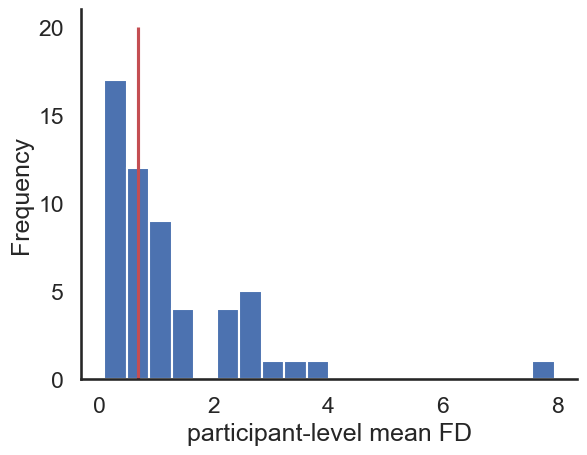

In [75]:
subtempdata = data.loc[:,['sub','age','sex','grandmeanFD']].copy()
subtempdata = subtempdata.drop_duplicates()

subtempdata.loc[:,'grandmeanFD'].plot(kind='hist', bins=20)
plt.vlines(np.nanpercentile(subtempdata.loc[:,'grandmeanFD'].to_numpy(), 50), ymin=0, ymax=20, color='r')
print(np.nanpercentile(subtempdata.loc[:,'grandmeanFD'].to_numpy(), 50))
sns.despine()
plt.xlabel('participant-level mean FD')
plt.show()
plt.close()

### mixed effects models examining movie and other factors predicting motion

In [83]:
## add zero for ref within participants
tdata = data.dropna(subset=['meanFD', 'movie','age','sex'], ignore_index=False, axis=0).copy()
indx = tdata.index[-1]

for sub in np.unique(tdata['sub']):
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_summary.csv'.format(sub)), index_col=0)
    tdata.loc[indx, 'sub'] = sub
    tdata.loc[indx, 'movie'] = 'aaa_ref'
    tdata.loc[indx, 'meanFD'] = data.loc[:,'meanFD'].mean()
    tdata.loc[indx, 'pcCens9'] = data.loc[:,'pcCens9'].mean()
    tdata.loc[indx, 'pcCens2'] = data.loc[:,'pcCens2'].mean()
    tdata.loc[indx, 'grandmeanFD'] = subdata.loc[:, 'meanFD'].mean()
    if tdata.loc[indx, 'grandmeanFD'] >= 0.68:
        tdata.loc[indx, 'motiongroup'] = 'high'
    else:
        tdata.loc[indx, 'motiongroup'] = 'low'
    try:
        data.loc[indx, 'age'] = subinfo.loc[sub, 'child_age_realtime']
        data.loc[indx, 'sex'] = subinfo.loc[sub, 'c_gender']
        data.loc[indx, 'interest'] = subdata.loc[movie, 'interest']
        data.loc[indx, 'pos_aff'] = subdata.loc[movie, 'pos_aff']
        data.loc[indx, 'neg_aff'] = subdata.loc[movie, 'neg_aff']
        data.loc[indx, 'aff_intensity'] = subdata.loc[movie, 'aff_intensity']
    except:
        pass
    indx += 1

tdata = tdata.sort_values('movie', ignore_index=True)
tdata = tdata.dropna(subset=['meanFD', 'movie','age','sex'], axis=0,ignore_index=False)
#tdata.head()

#### Full sample

The below cell has results from a mixed effect model predicting FD from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST motion to MOST after accounting for these features is listed after the model results below.

In [78]:
res = smf.mixedlm('meanFD ~ movie + age + sex', groups='sub', data=tdata).fit()
print(res.summary())

print('============ Movies listed from least to most motion  ============')
movies = res.params.iloc[1:-3]
movies = movies.sort_values(ascending=True)
for a in movies.index:
    print(a.replace('movie[T.','').replace(']',''))

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      meanFD   
No. Observations:      245          Method:                  REML     
No. Groups:            44           Scale:                   1.1625   
Min. group size:       1            Log-Likelihood:          -381.2738
Max. group size:       7            Converged:               Yes      
Mean group size:       5.6                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.035    0.481  6.314 0.000  2.093  3.977
movie[T.aeronaut]            0.366    0.449  0.815 0.415 -0.514  1.246
movie[T.air_mater]           0.538    0.409  1.316 0.188 -0.263  1.338
movie[T.bao]                 0.580    0.493  1.175 0.240 -0.387  1.547
movie[T.birds]         

The below cell has results from a mixed effect model predicting percent censored at 0.2mm from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST censored to MOST after accounting for these features is listed after the model results below.

In [79]:
res = smf.mixedlm('pcCens9 ~ movie + age + sex', groups='sub', data=tdata).fit()
print(res.summary())

movies = res.params.iloc[1:-3]
movies = movies.sort_values(ascending=True)
print('============ Movies listed from least to most censored  ============')
for a in movies.index:
    print(a.replace('movie[T.','').replace(']',''))

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      pcCens9  
No. Observations:        245          Method:                  REML     
No. Groups:              44           Scale:                   93.9131  
Min. group size:         1            Log-Likelihood:          -880.6629
Max. group size:         7            Converged:               Yes      
Mean group size:         5.6                                            
------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    51.444    5.383  9.557 0.000  40.894 61.994
movie[T.aeronaut]             9.101    4.423  2.058 0.040   0.433 17.769
movie[T.air_mater]           10.124    4.033  2.510 0.012   2.220 18.028
movie[T.bao]                 13.233    4.727  2.800 0.005   3.969 22.

The below cell has results from a mixed effect model predicting percent censored at 0.2mm from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST censored to MOST after accounting for these features is listed after the model results below.

In [80]:
res = smf.mixedlm('pcCens2 ~ movie + age + sex', groups='sub', data=tdata).fit()
print(res.summary())

movies = res.params.iloc[1:-3]
movies = movies.sort_values(ascending=True)
print('============ Movies listed from least to most censored  ============')
for a in movies.index:
    print(a.replace('movie[T.','').replace(']',''))

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       pcCens2  
No. Observations:       245           Method:                   REML     
No. Groups:             44            Scale:                    148.1101 
Min. group size:        1             Log-Likelihood:           -933.7626
Max. group size:        7             Converged:                Yes      
Mean group size:        5.6                                              
-------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                    94.578    6.990 13.530 0.000  80.877 108.279
movie[T.aeronaut]            16.917    5.644  2.997 0.003   5.855  27.980
movie[T.air_mater]           12.233    5.143  2.378 0.017   2.152  22.314
movie[T.bao]                 15.403    5.997  2.568 0.01

#### high motion subs only

In [84]:
tdata = tdata.loc[tdata['motiongroup']=='high',:]

The below cell has results from a mixed effect model predicting FD from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST motion to MOST after accounting for these features is listed after the model results below.

In [85]:
res = smf.mixedlm('meanFD ~ movie + age + sex', groups='sub', data=tdata).fit()
print(res.summary())

print('============ Movies listed from least to most motion  ============')
movies = res.params.iloc[1:-3]
movies = movies.sort_values(ascending=True)
for a in movies.index:
    print(a.replace('movie[T.','').replace(']',''))

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      meanFD   
No. Observations:      133          Method:                  REML     
No. Groups:            25           Scale:                   2.3263   
Min. group size:       1            Log-Likelihood:          -223.5272
Max. group size:       7            Converged:               No       
Mean group size:       5.3                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    2.469    0.672  3.676 0.000  1.153  3.785
movie[T.aeronaut]            0.582    0.834  0.699 0.485 -1.052  2.217
movie[T.air_mater]           0.569    0.701  0.811 0.417 -0.805  1.942
movie[T.bao]                 0.396    0.835  0.475 0.635 -1.240  2.032
movie[T.birds]         

The below cell has results from a mixed effect model predicting percent censored at 0.2mm from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST censored to MOST after accounting for these features is listed after the model results below.

In [86]:
res = smf.mixedlm('pcCens9 ~ movie + age + sex', groups='sub', data=tdata).fit()
print(res.summary())

movies = res.params.iloc[1:-3]
movies = movies.sort_values(ascending=True)
print('============ Movies listed from least to most censored  ============')
for a in movies.index:
    print(a.replace('movie[T.','').replace(']',''))

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      pcCens9  
No. Observations:       133          Method:                  REML     
No. Groups:             25           Scale:                   168.2179 
Min. group size:        1            Log-Likelihood:          -466.1070
Max. group size:        7            Converged:               Yes      
Mean group size:        5.3                                            
-----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   40.433    7.880  5.131 0.000  24.988 55.877
movie[T.aeronaut]           15.632    7.861  1.988 0.047   0.224 31.040
movie[T.air_mater]           9.094    6.514  1.396 0.163  -3.673 21.862
movie[T.bao]                16.655    7.789  2.138 0.033   1.388 31.922
movie[T.b

The below cell has results from a mixed effect model predicting percent censored at 0.2mm from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST censored to MOST after accounting for these features is listed after the model results below.

In [87]:
res = smf.mixedlm('pcCens2 ~ movie + age + sex', groups='sub', data=tdata).fit()
print(res.summary())

movies = res.params.iloc[1:-3]
movies = movies.sort_values(ascending=True)
print('============ Movies listed from least to most censored  ============')
for a in movies.index:
    print(a.replace('movie[T.','').replace(']',''))

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      pcCens2  
No. Observations:        133          Method:                  REML     
No. Groups:              25           Scale:                   237.1583 
Min. group size:         1            Log-Likelihood:          -487.0234
Max. group size:         7            Converged:               Yes      
Mean group size:         5.3                                            
------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    75.980    9.823  7.735 0.000  56.728 95.233
movie[T.aeronaut]            19.959    9.529  2.095 0.036   1.283 38.634
movie[T.air_mater]            6.429    7.877  0.816 0.414  -9.010 21.867
movie[T.bao]                 18.373    9.412  1.952 0.051  -0.074 36.

### raw data plots - high motion only

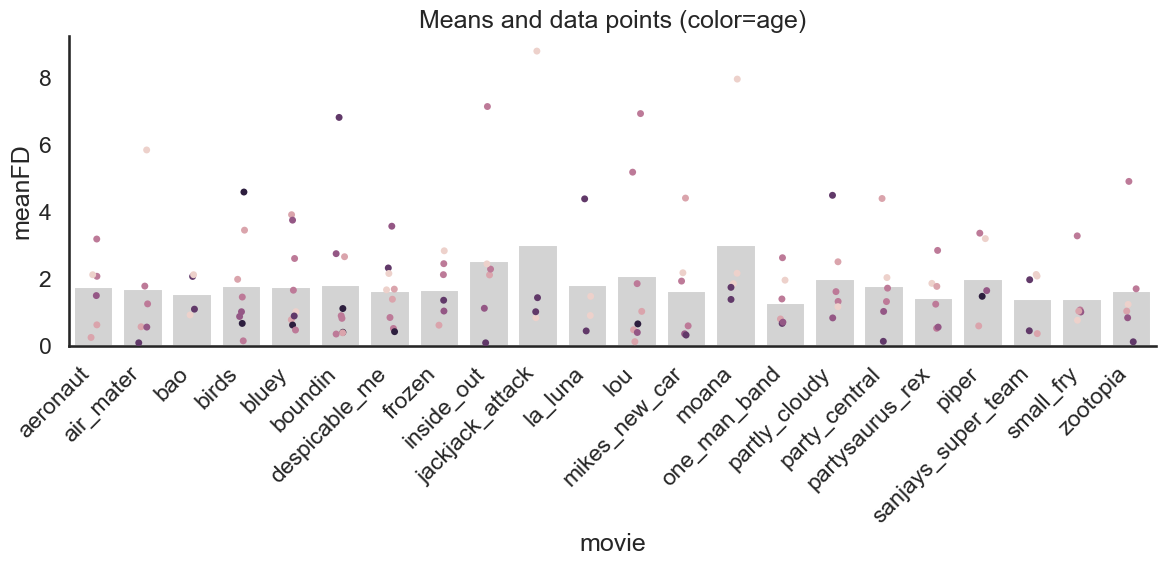

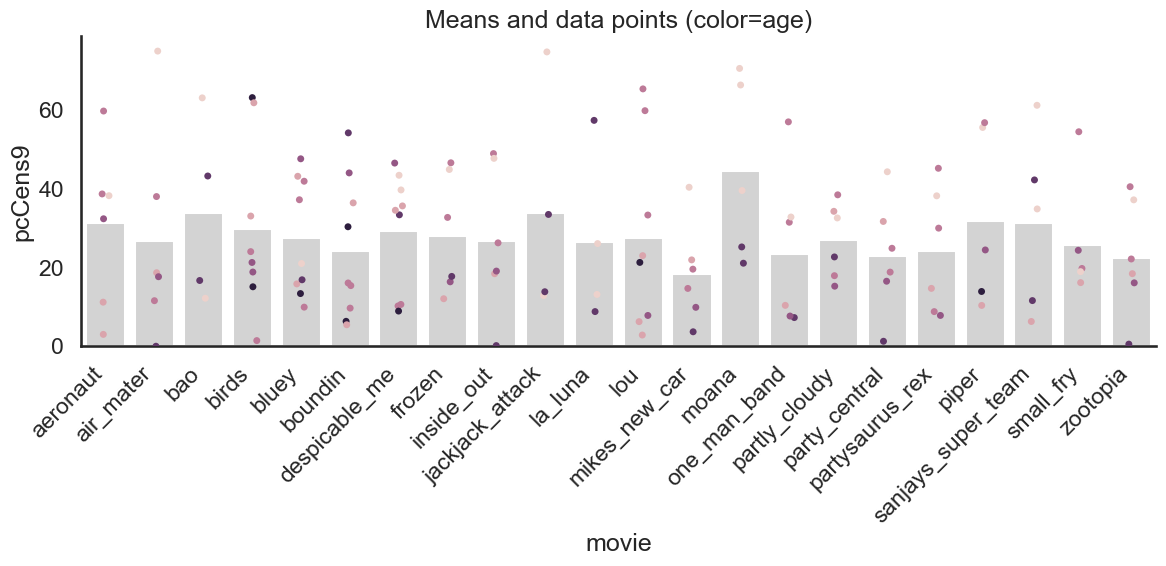

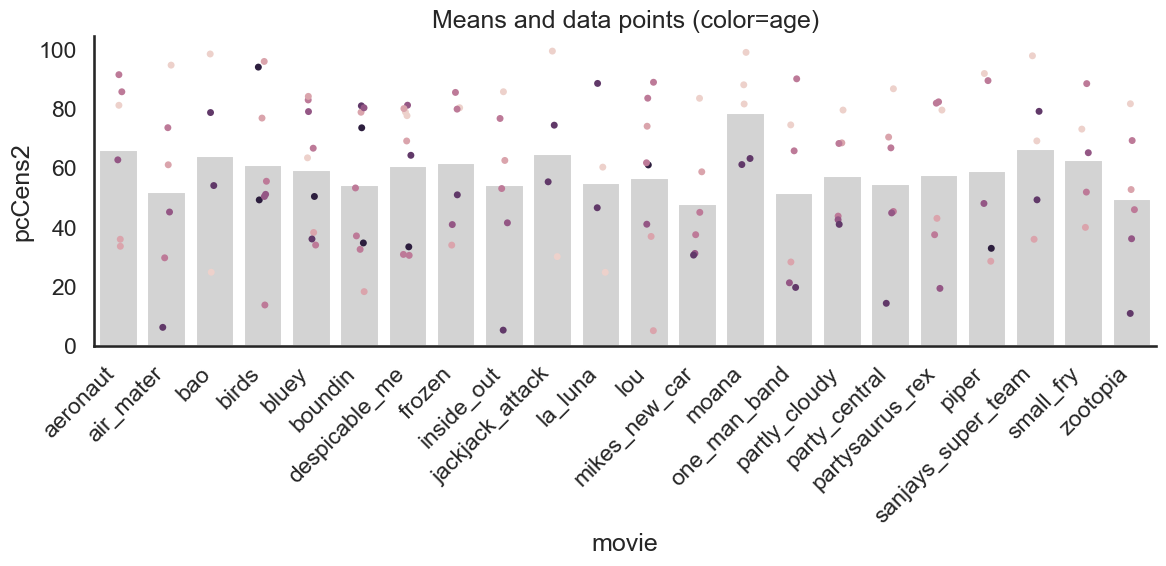

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


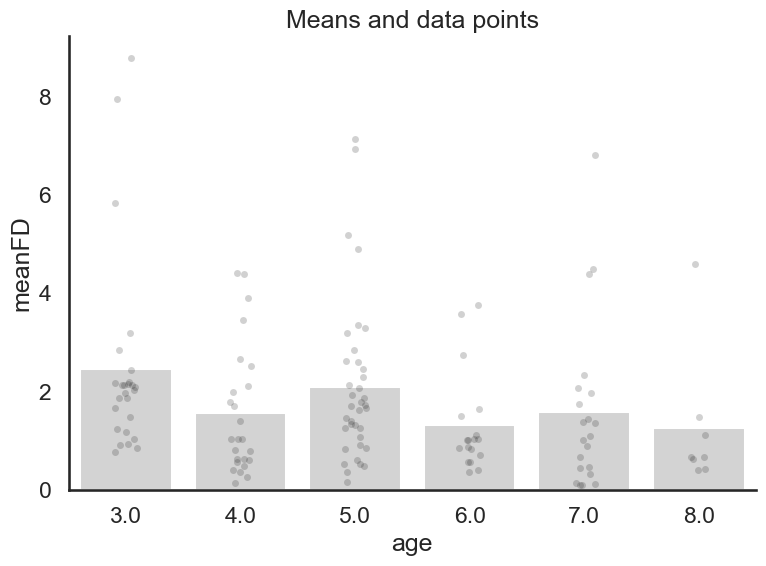

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


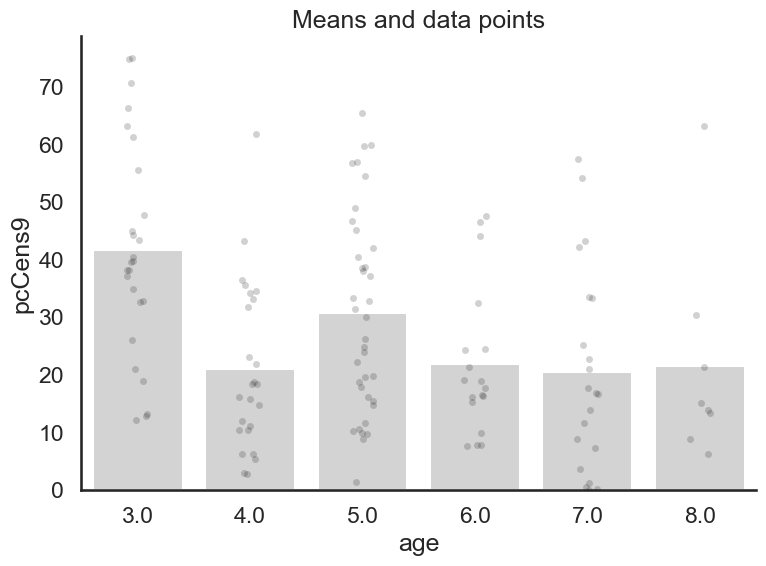

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


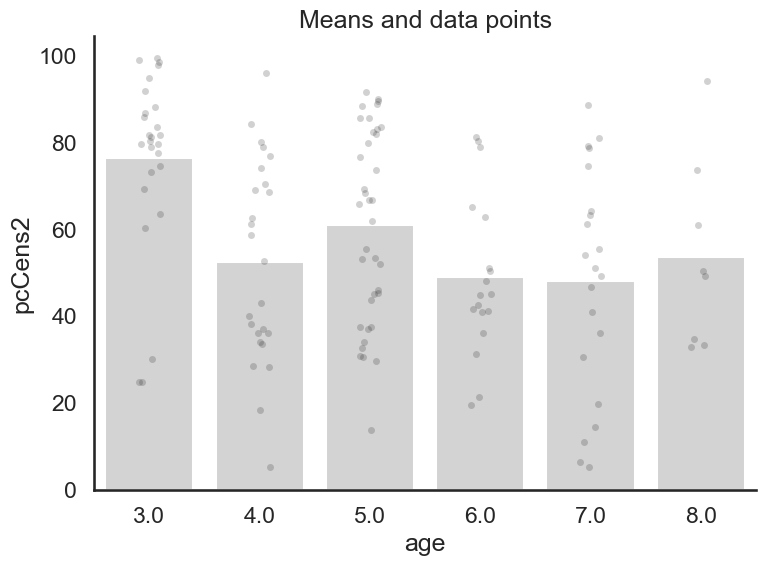

In [90]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data.loc[data['motiongroup']=='high',:], color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data.loc[data['motiongroup']=='high',:], hue='age')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.title('Means and data points (color=age)')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'highmotion_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v, x='age', data=data.loc[data['motiongroup']=='high',:], color='lightgray',errwidth=0)
    sns.stripplot(y=v, x='age', data=data.loc[data['motiongroup']=='high',:], color='k', alpha=0.2)
    plt.legend().remove()
    sns.despine()
    plt.title('Means and data points')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'highmotion_age_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

### raw data plots - full sample

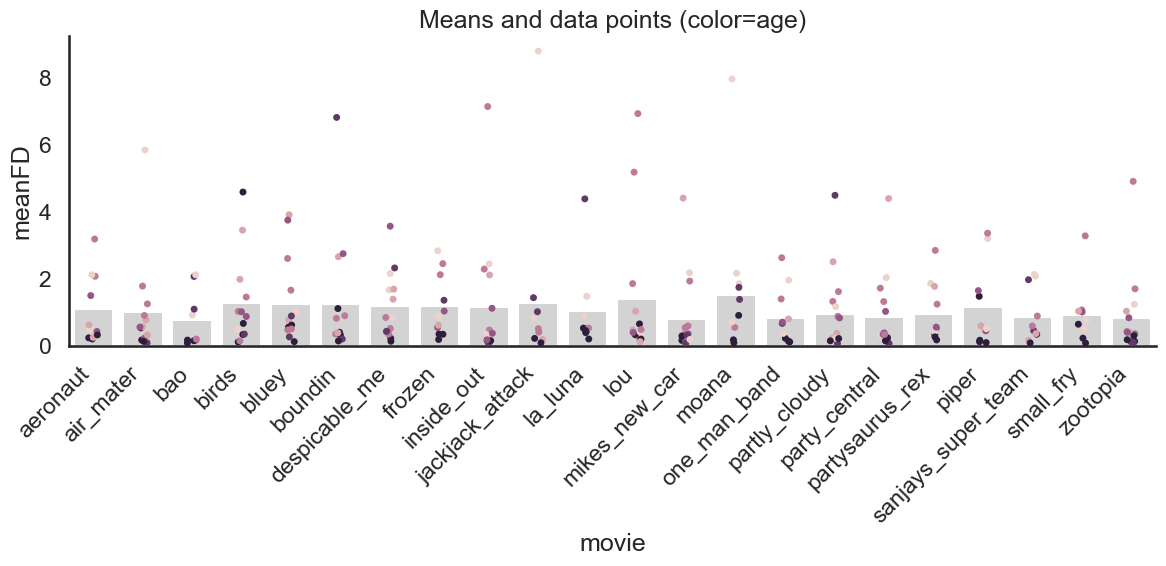

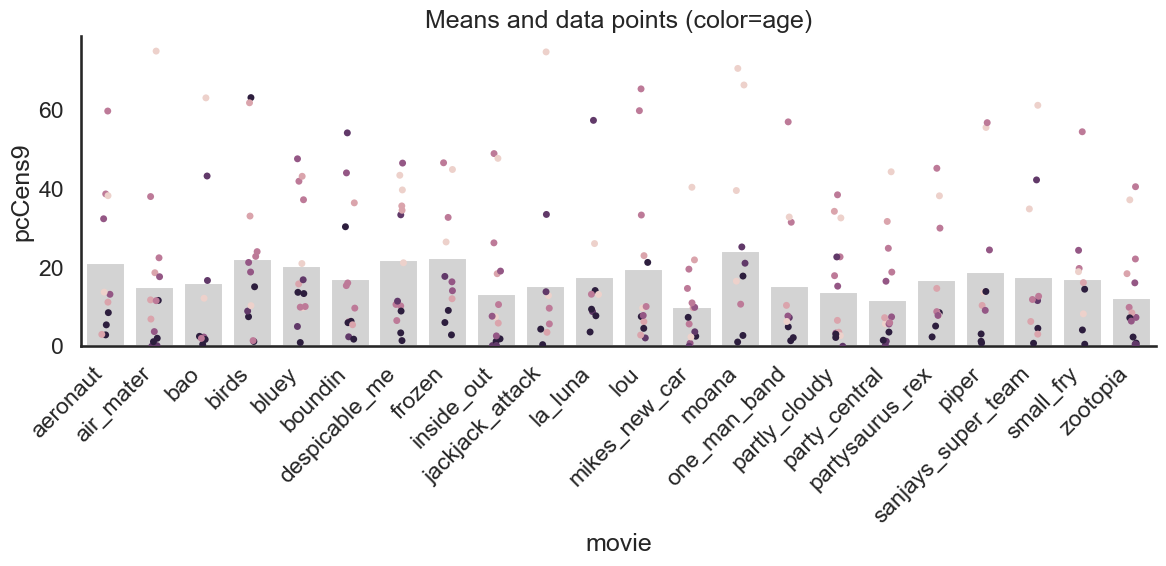

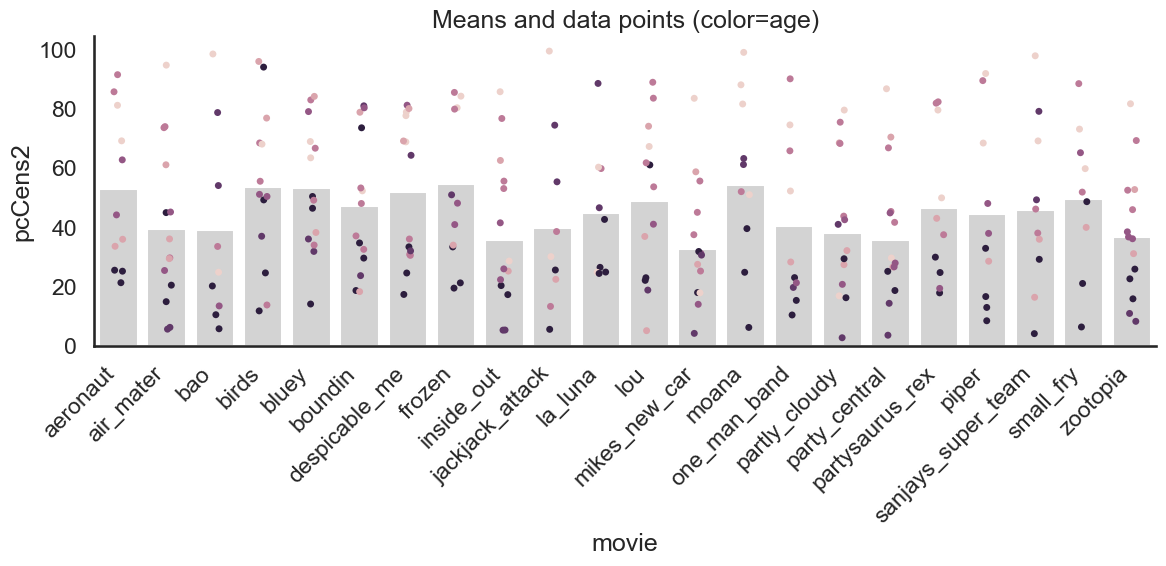

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


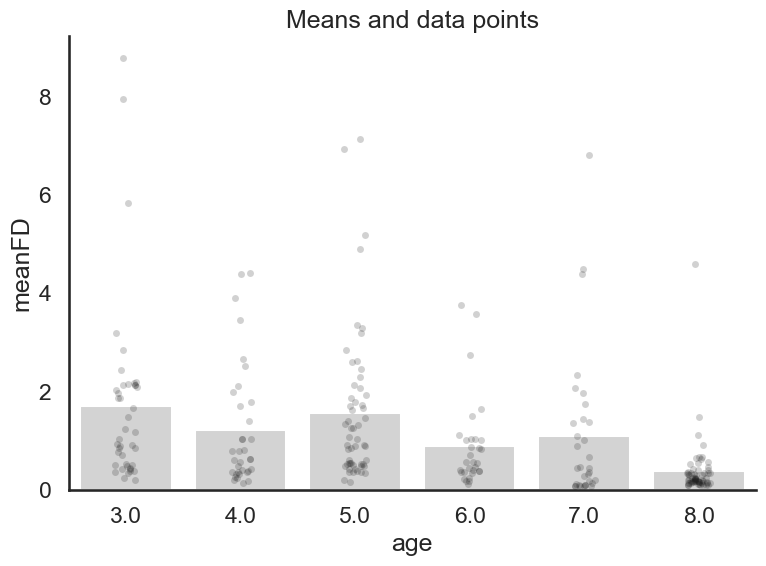

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


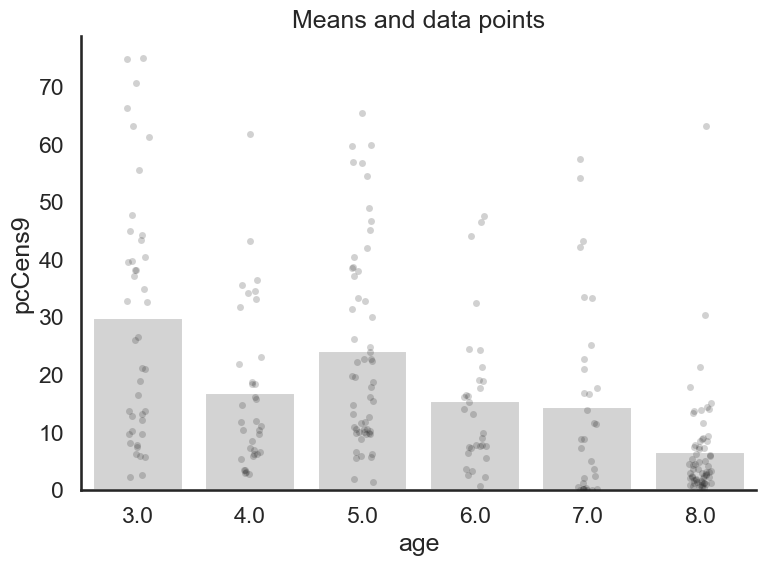

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


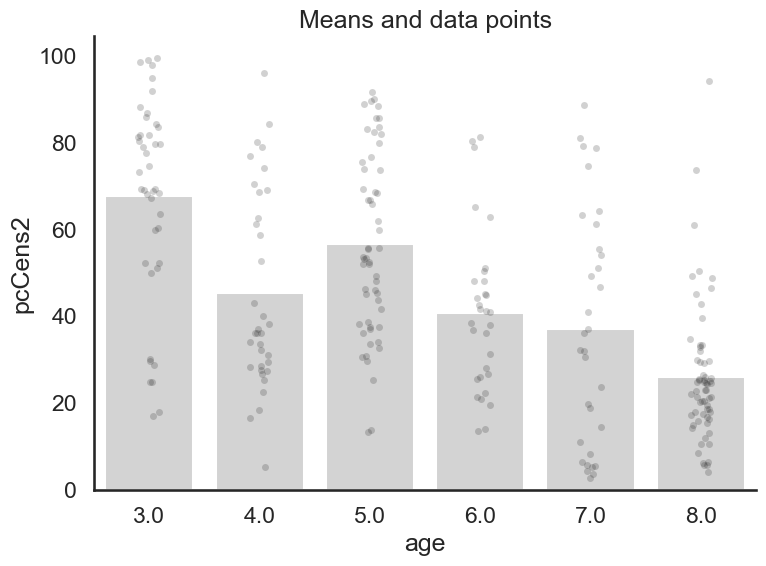

In [91]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data, hue='age')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.title('Means and data points (color=age)')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v, x='age', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v, x='age', data=data, color='k', alpha=0.2)
    plt.legend().remove()
    sns.despine()
    plt.title('Means and data points')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

### analyses of clip category - high motion sample


################### meanFD - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              1.8017   
Min. group size:  1       Log-Likelihood:     -230.4244
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.501    0.782  4.479 0.000  1.969  5.033
human         0.176    0.265  0.663 0.507 -0.343  0.694
age          -0.172    0.115 -1.501 0.133 -0.397  0.053
sex          -0.626    0.352 -1.777 0.076 -1.317  0.064
sub Var       0.599    0.304                           



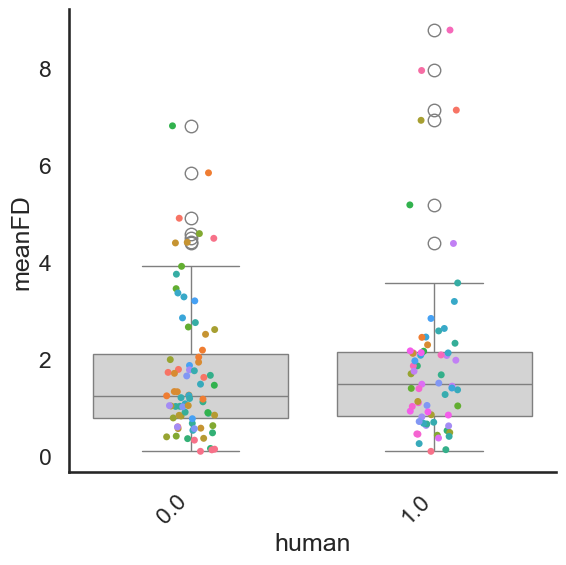


################### meanFD - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              1.7867   
Min. group size:  1       Log-Likelihood:     -229.7166
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.416    0.766  4.458 0.000  1.915  4.918
speaking      0.358    0.260  1.375 0.169 -0.152  0.868
age          -0.175    0.113 -1.548 0.122 -0.398  0.047
sex          -0.657    0.349 -1.880 0.060 -1.341  0.028
sub Var       0.577    0.299                           



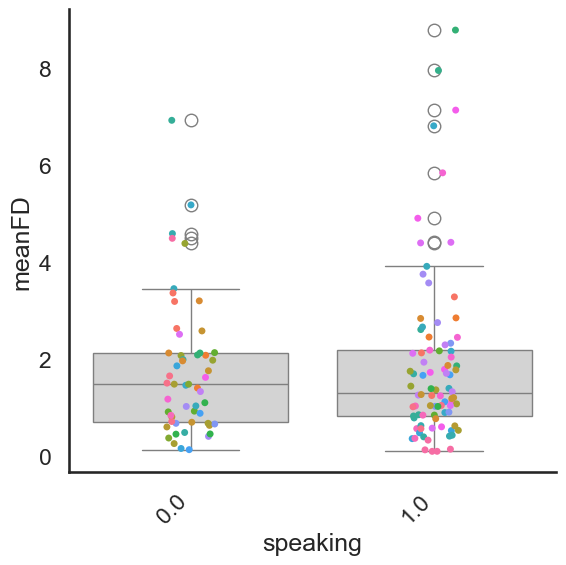


################### meanFD - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              1.8091   
Min. group size:  1       Log-Likelihood:     -230.1229
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.791    0.770  4.924 0.000  2.282  5.301
contained    -0.271    0.284 -0.956 0.339 -0.828  0.285
age          -0.176    0.113 -1.554 0.120 -0.397  0.046
sex          -0.619    0.349 -1.775 0.076 -1.302  0.064
sub Var       0.561    0.292                           



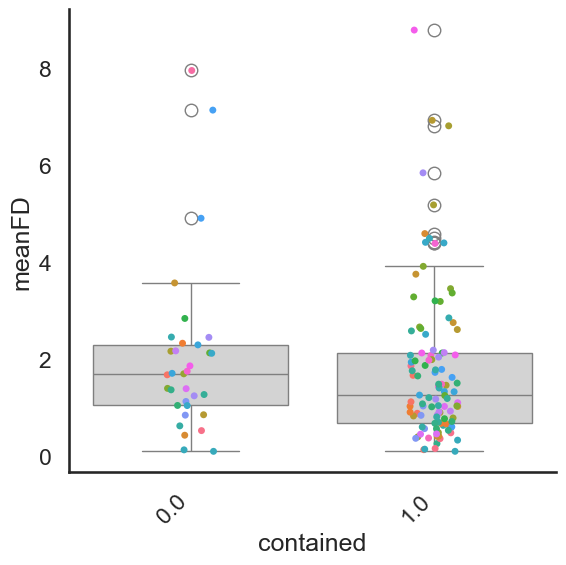


################### pcCens9 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              133.4190 
Min. group size:  1       Log-Likelihood:     -505.2732
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   52.496    9.210  5.700 0.000  34.446 70.547
human        1.502    2.383  0.630 0.529  -3.169  6.173
age         -2.257    1.222 -1.847 0.065  -4.652  0.138
sex         -9.706    3.989 -2.433 0.015 -17.524 -1.888
sub Var    143.620    5.448                            



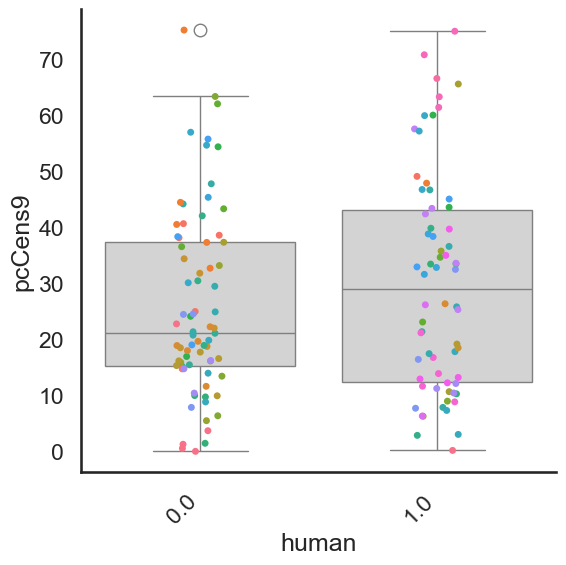


################### pcCens9 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              133.2771 
Min. group size:  1       Log-Likelihood:     -505.3823
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   52.769    9.233  5.715 0.000  34.674 70.865
speaking     1.141    2.299  0.496 0.620  -3.365  5.646
age         -2.293    1.222 -1.876 0.061  -4.688  0.102
sex         -9.766    4.003 -2.440 0.015 -17.612 -1.920
sub Var    145.521    5.507                            



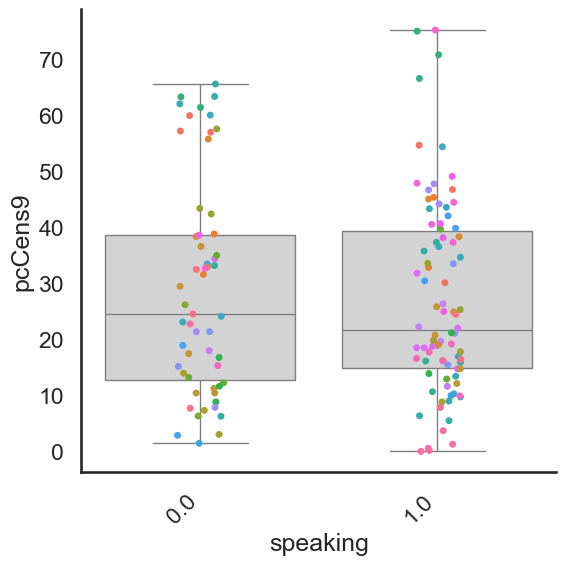


################### pcCens9 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              131.8721 
Min. group size:  1       Log-Likelihood:     -504.7193
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   54.695    9.179  5.959 0.000  36.705 72.686
contained   -2.938    2.438 -1.205 0.228  -7.716  1.839
age         -2.223    1.220 -1.821 0.069  -4.614  0.169
sex         -9.337    4.016 -2.325 0.020 -17.208 -1.465
sub Var    144.747    5.511                            



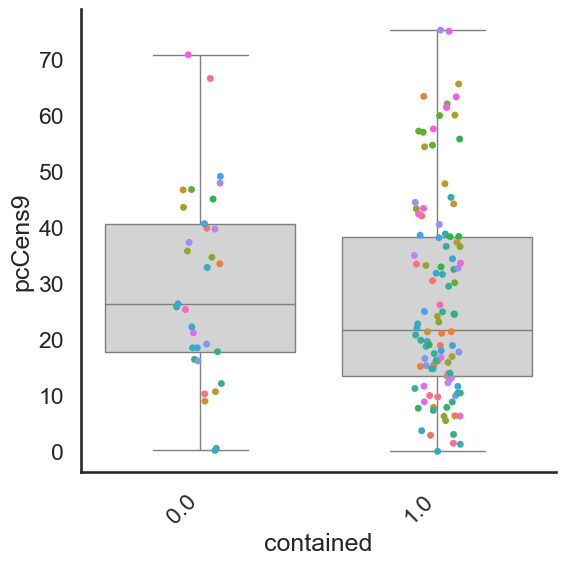


################### pcCens2 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              221.5116 
Min. group size:  1       Log-Likelihood:     -536.5418
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  92.560   11.797  7.846 0.000  69.438 115.683
human       0.232    3.072  0.076 0.940  -5.789   6.253
age        -3.144    1.548 -2.031 0.042  -6.179  -0.110
sex       -12.909    5.189 -2.488 0.013 -23.079  -2.738
sub Var   240.606    6.561                             



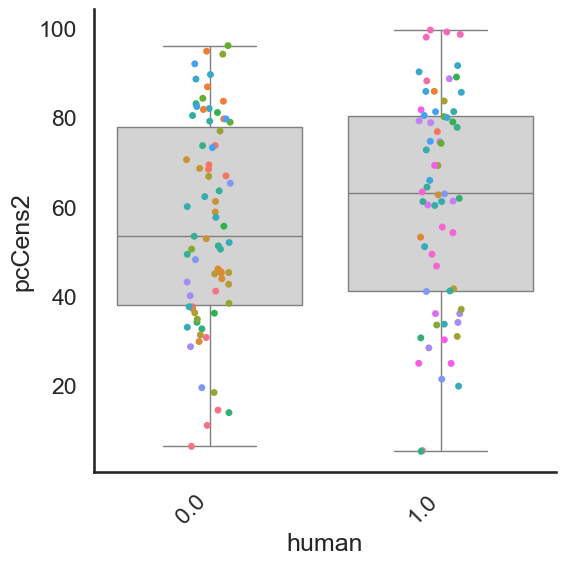


################### pcCens2 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              217.9729 
Min. group size:  1       Log-Likelihood:     -535.8910
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  90.058   11.849  7.601 0.000  66.835 113.280
speaking    3.465    2.943  1.177 0.239  -2.303   9.232
age        -3.044    1.545 -1.971 0.049  -6.071  -0.017
sex       -12.972    5.191 -2.499 0.012 -23.147  -2.798
sub Var   244.150    6.687                             



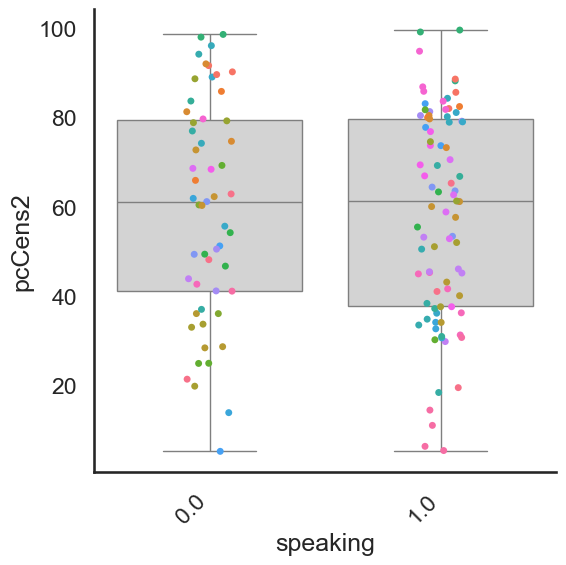


################### pcCens2 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              219.2698 
Min. group size:  1       Log-Likelihood:     -536.0401
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  93.825   11.718  8.007 0.000  70.858 116.792
contained  -3.070    3.143 -0.977 0.329  -9.229   3.090
age        -3.045    1.545 -1.970 0.049  -6.074  -0.016
sex       -12.481    5.222 -2.390 0.017 -22.716  -2.245
sub Var   241.885    6.624                             



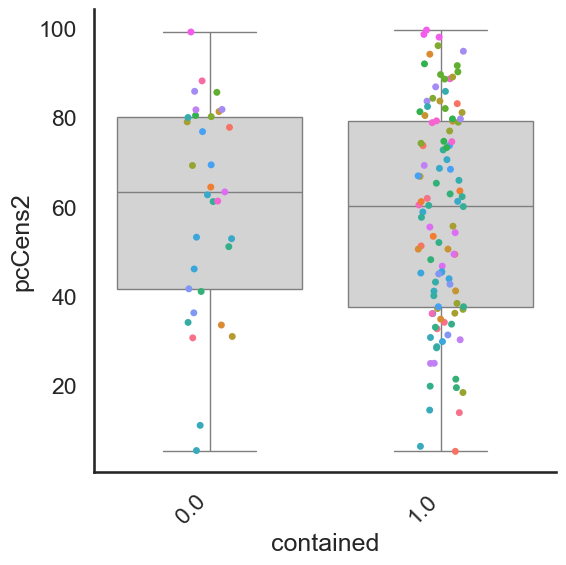

In [92]:
for v in ['meanFD','pcCens9','pcCens2']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1} + age + sex'.format(v,f), groups='sub', 
                          data=temp.loc[temp['motiongroup']=='high',:]).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.boxplot(y=v,x=f, data=data.loc[data['motiongroup']=='high',:], color='lightgray')
        sns.stripplot(y=v,x=f, data=data.loc[data['motiongroup']=='high',:], hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'highsample_feature_{0}_motion_{1}_plot.png'.format(f,v)), 
                    dpi=200)
        plt.show()
        plt.close()
        
        

### analyses of clip category - full sample


################### meanFD - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8870   
Min. group size:  1       Log-Likelihood:     -383.0418
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.971    0.540  5.505 0.000  1.913  4.029
human         0.060    0.141  0.425 0.671 -0.217  0.337
age          -0.221    0.064 -3.477 0.001 -0.346 -0.097
sex          -0.424    0.216 -1.959 0.050 -0.848  0.000
sub Var       0.764    0.296                           



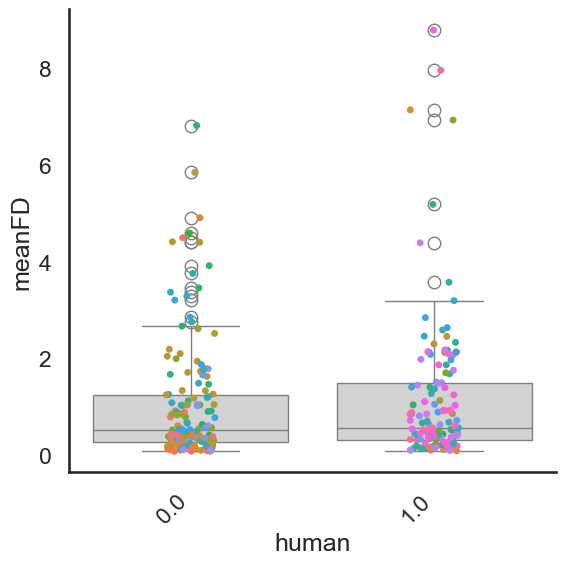


################### meanFD - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8804   
Min. group size:  1       Log-Likelihood:     -382.1702
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.878    0.538  5.346 0.000  1.823  3.933
speaking      0.189    0.132  1.438 0.150 -0.069  0.447
age          -0.225    0.063 -3.583 0.000 -0.348 -0.102
sex          -0.407    0.216 -1.885 0.059 -0.830  0.016
sub Var       0.757    0.293                           



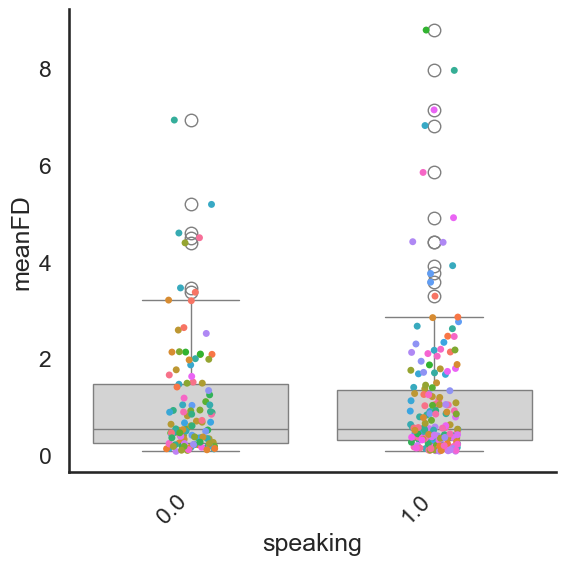


################### meanFD - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8857   
Min. group size:  1       Log-Likelihood:     -382.5689
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.128    0.542  5.768 0.000  2.065  4.190
contained    -0.150    0.142 -1.061 0.289 -0.428  0.127
age          -0.223    0.063 -3.537 0.000 -0.346 -0.099
sex          -0.429    0.215 -1.992 0.046 -0.851 -0.007
sub Var       0.751    0.291                           



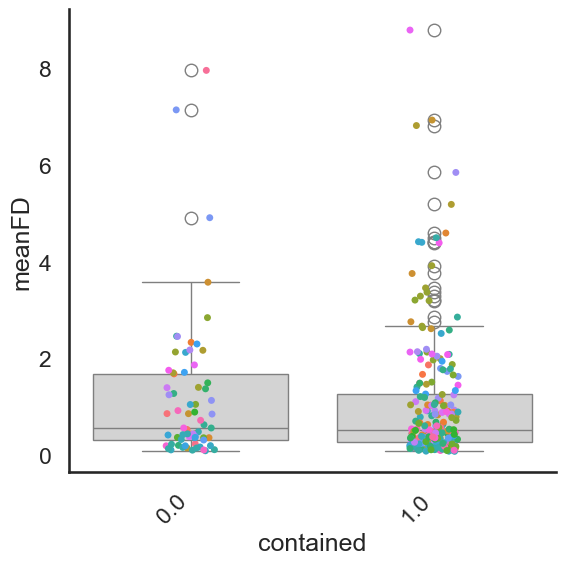


################### pcCens9 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              74.1106  
Min. group size:  1       Log-Likelihood:     -946.1515
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    39.480    6.190  6.378 0.000 27.348 51.612
human         0.472    1.332  0.354 0.723 -2.140  3.083
age          -2.682    0.703 -3.816 0.000 -4.059 -1.304
sex          -4.680    2.372 -1.973 0.049 -9.330 -0.030
sub Var     160.949    5.323                           



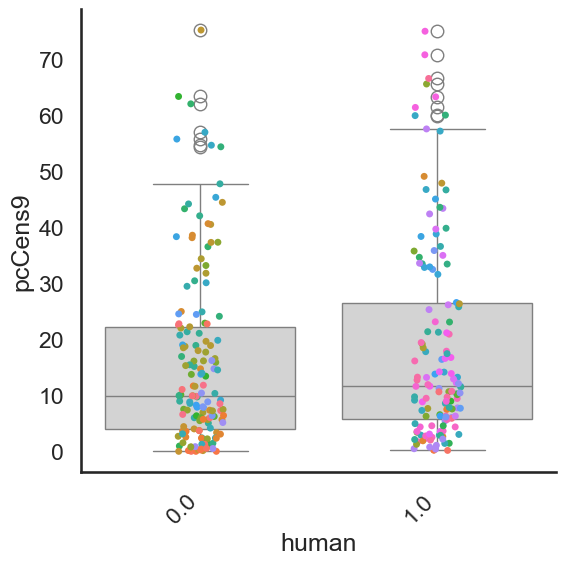


################### pcCens9 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              73.9440  
Min. group size:  1       Log-Likelihood:     -946.0481
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    39.124    6.191  6.319 0.000 26.989 51.259
speaking      0.869    1.219  0.712 0.476 -1.521  3.258
age          -2.717    0.695 -3.911 0.000 -4.078 -1.355
sex          -4.520    2.373 -1.905 0.057 -9.171  0.131
sub Var     161.229    5.327                           



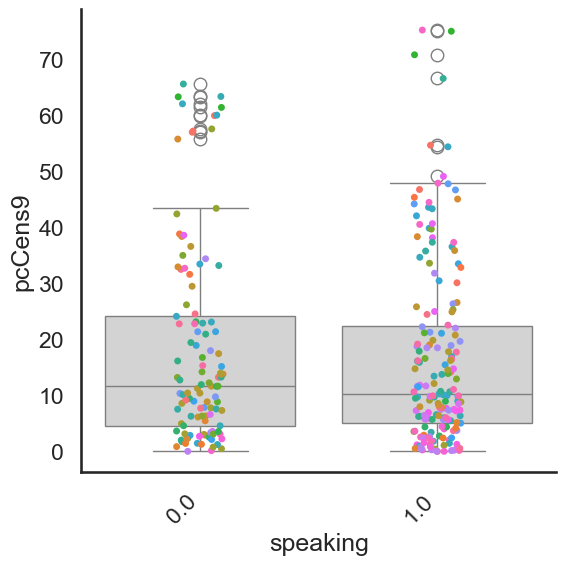


################### pcCens9 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              72.9257  
Min. group size:  1       Log-Likelihood:     -944.4789
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    41.454    6.164  6.725 0.000 29.373 53.536
contained    -2.425    1.287 -1.884 0.060 -4.948  0.098
age          -2.646    0.693 -3.819 0.000 -4.004 -1.288
sex          -4.759    2.354 -2.021 0.043 -9.373 -0.144
sub Var     160.472    5.330                           



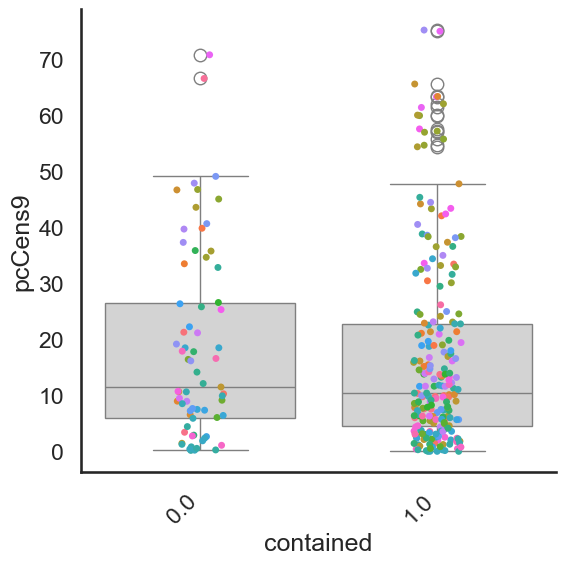


################### pcCens2 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 250     Method:             REML      
No. Groups:       49      Scale:              152.1951  
Min. group size:  1       Log-Likelihood:     -1034.1880
Max. group size:  6       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    75.146    9.000  8.349 0.000  57.505 92.786
human        -1.038    1.908 -0.544 0.586  -4.777  2.701
age          -3.913    1.053 -3.716 0.000  -5.976 -1.849
sex          -5.117    3.350 -1.527 0.127 -11.684  1.450
sub Var     323.302    7.469                            



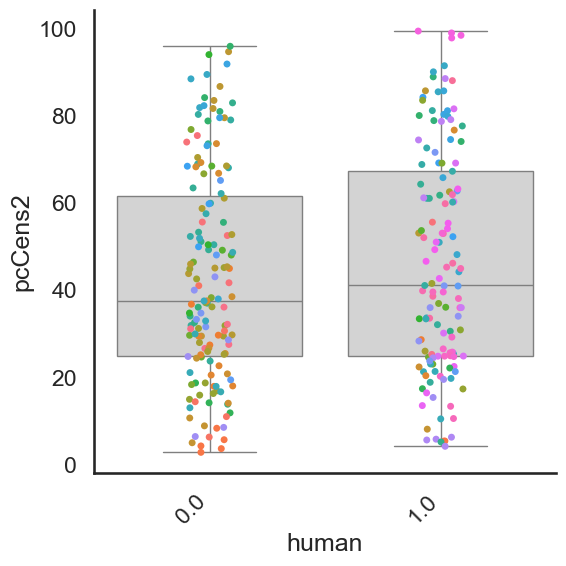


################### pcCens2 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 250     Method:             REML      
No. Groups:       49      Scale:              150.7896  
Min. group size:  1       Log-Likelihood:     -1033.5112
Max. group size:  6       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    72.323    9.016  8.022 0.000  54.653 89.994
speaking      2.358    1.741  1.354 0.176  -1.055  5.771
age          -3.809    1.043 -3.652 0.000  -5.854 -1.765
sex          -4.928    3.349 -1.472 0.141 -11.491  1.635
sub Var     325.988    7.571                            



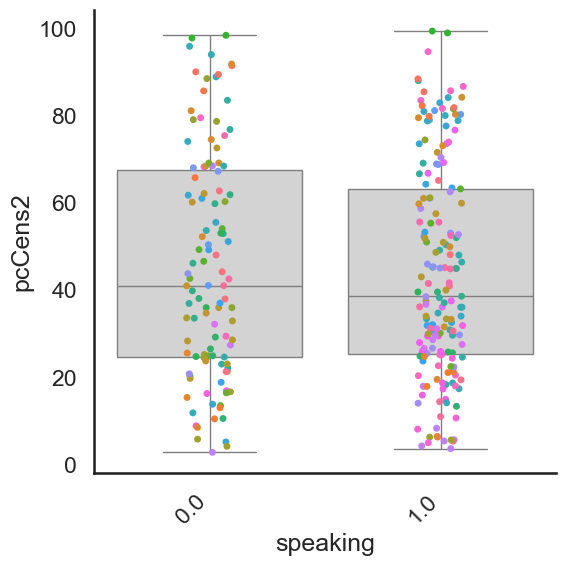


################### pcCens2 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 250     Method:             REML      
No. Groups:       49      Scale:              149.9427  
Min. group size:  1       Log-Likelihood:     -1032.9232
Max. group size:  6       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    76.298    8.968  8.508 0.000  58.721 93.875
contained    -3.144    1.845 -1.704 0.088  -6.761  0.473
age          -3.712    1.045 -3.552 0.000  -5.761 -1.664
sex          -5.385    3.331 -1.617 0.106 -11.914  1.144
sub Var     326.661    7.607                            



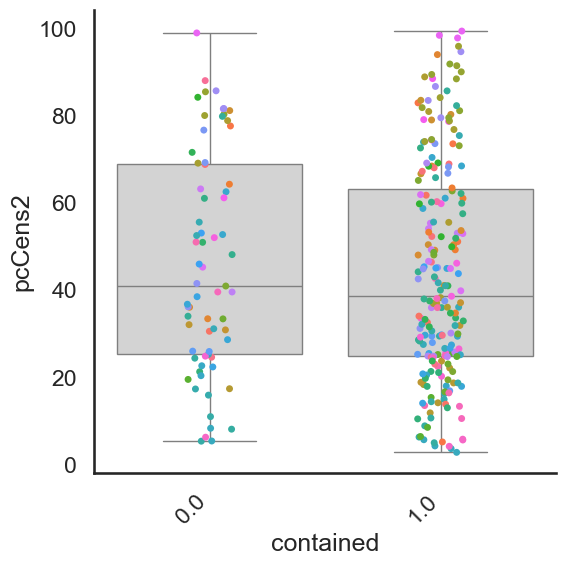

In [35]:
for v in ['meanFD','pcCens9','pcCens2']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1} + age + sex'.format(v,f), groups='sub', data=temp).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.boxplot(y=v,x=f, data=data, color='lightgray')
        sns.stripplot(y=v,x=f, data=data, hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'fullsample_feature_{0}_motion_{1}_plot.png'.format(f,v)), dpi=200)
        plt.show()
        plt.close()
        
        

# Plots by age group - full sample

## 3-4 year olds

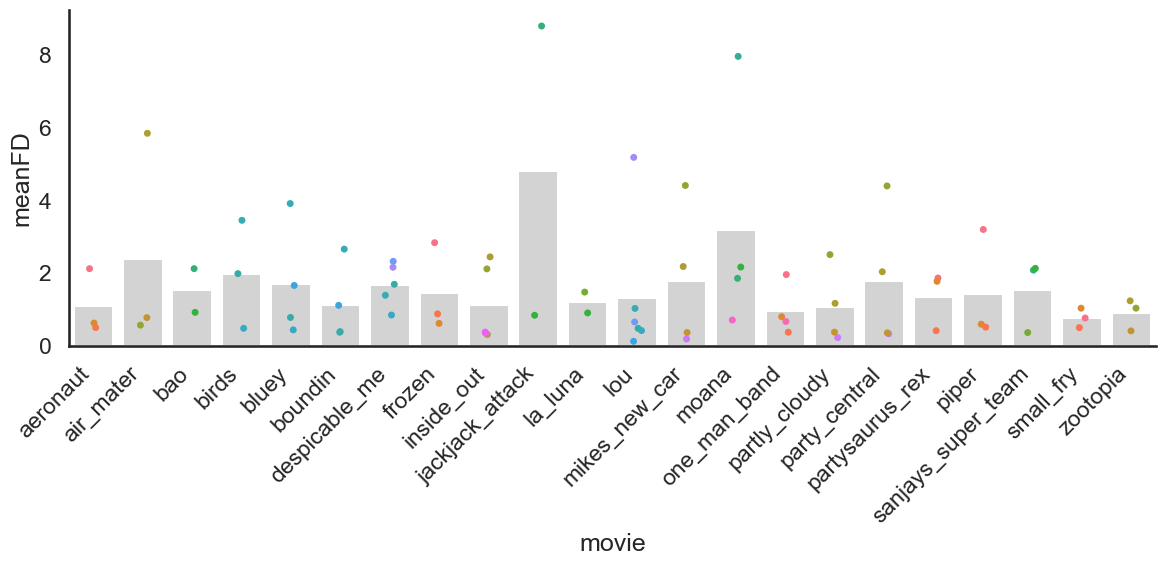

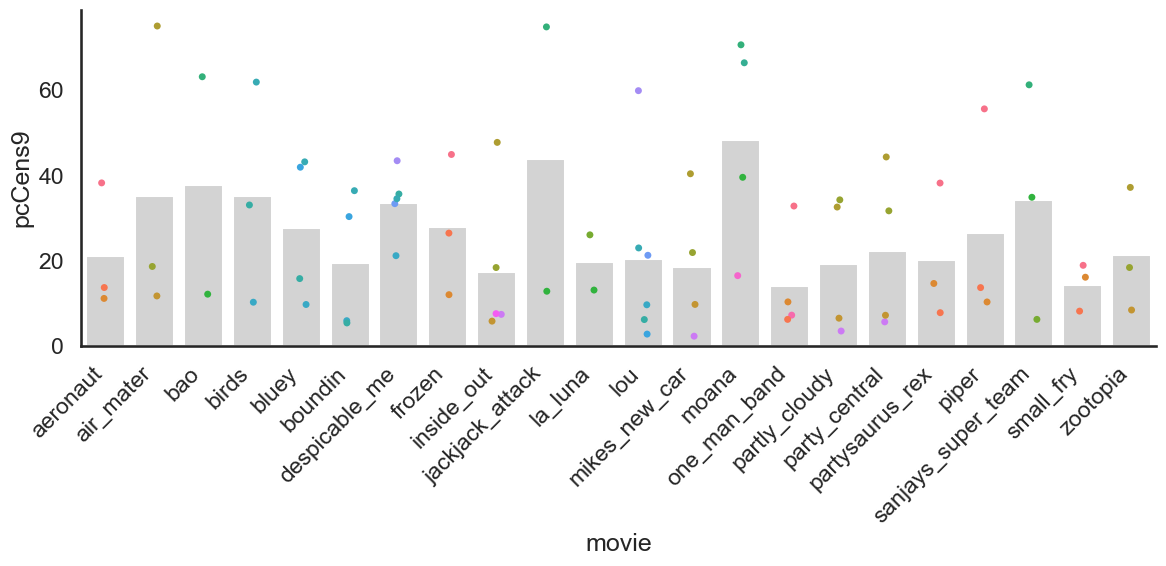

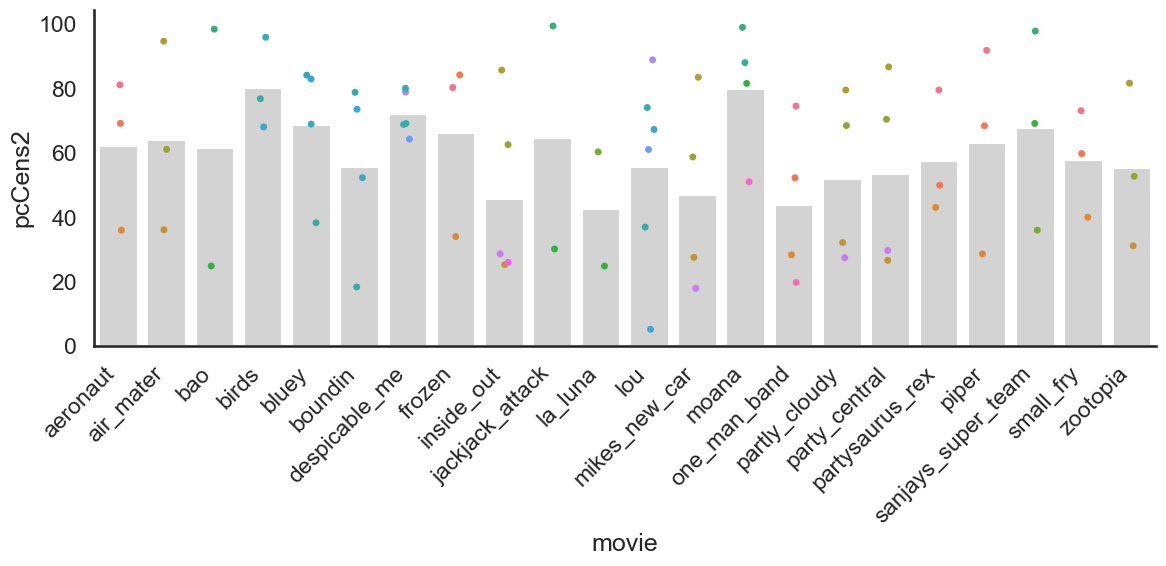

In [16]:
tempdata = data.loc[data['age']<5,:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages34_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

## 5-6 year olds

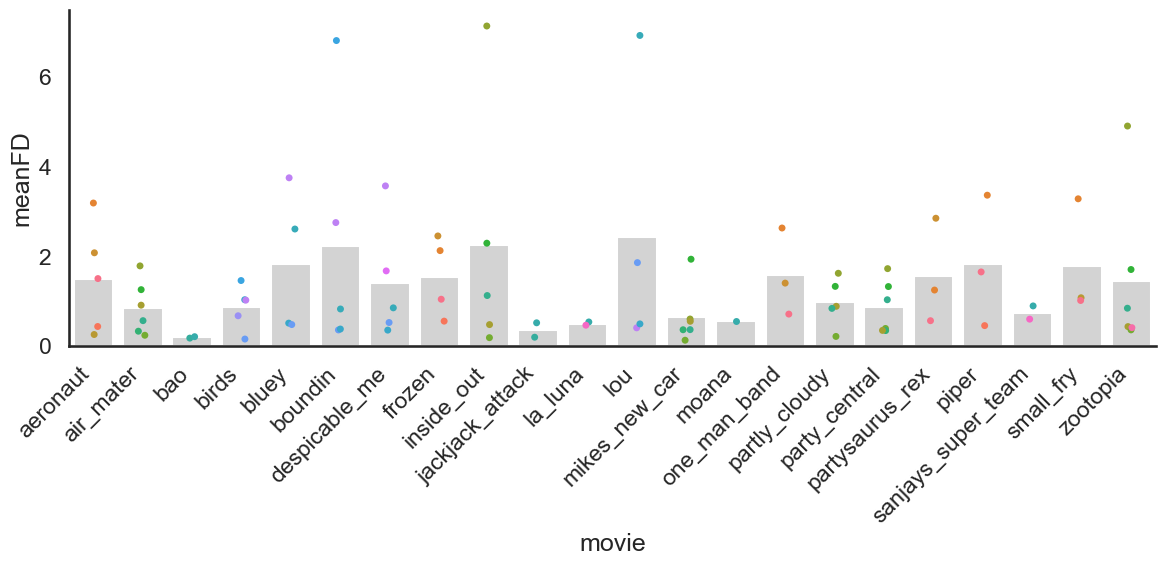

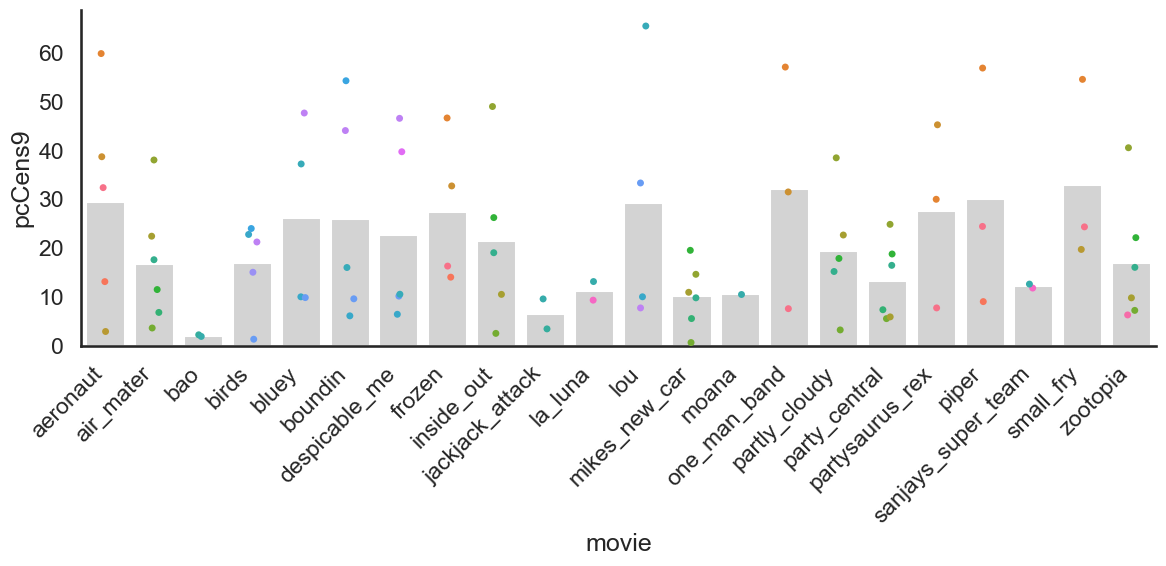

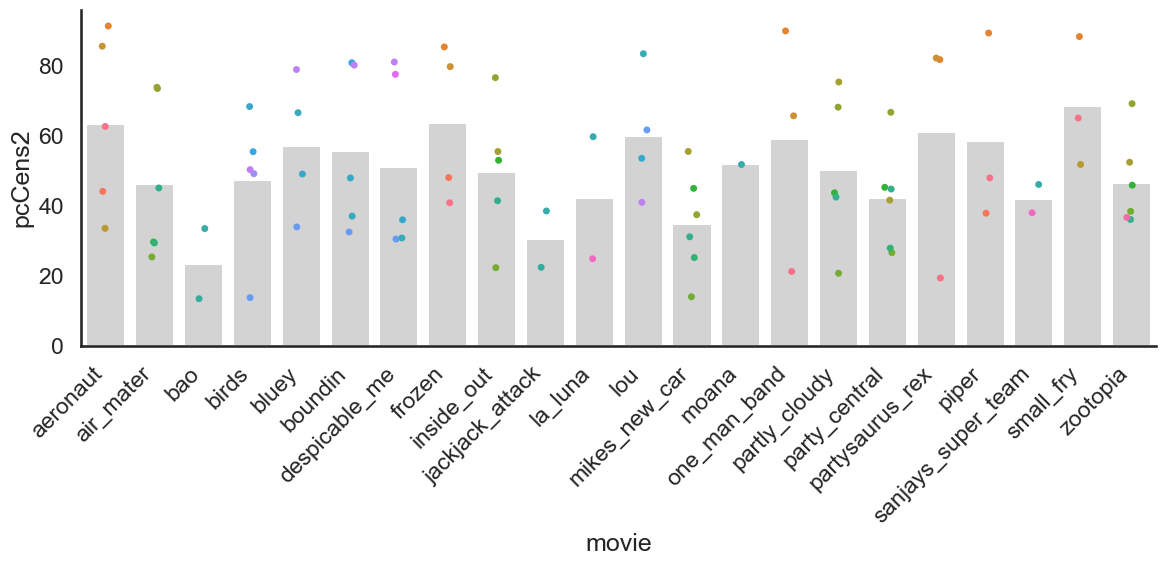

In [17]:
tempdata = data.loc[(data['age']==5) | (data['age']==6),:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages56_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

## 7-8 year olds

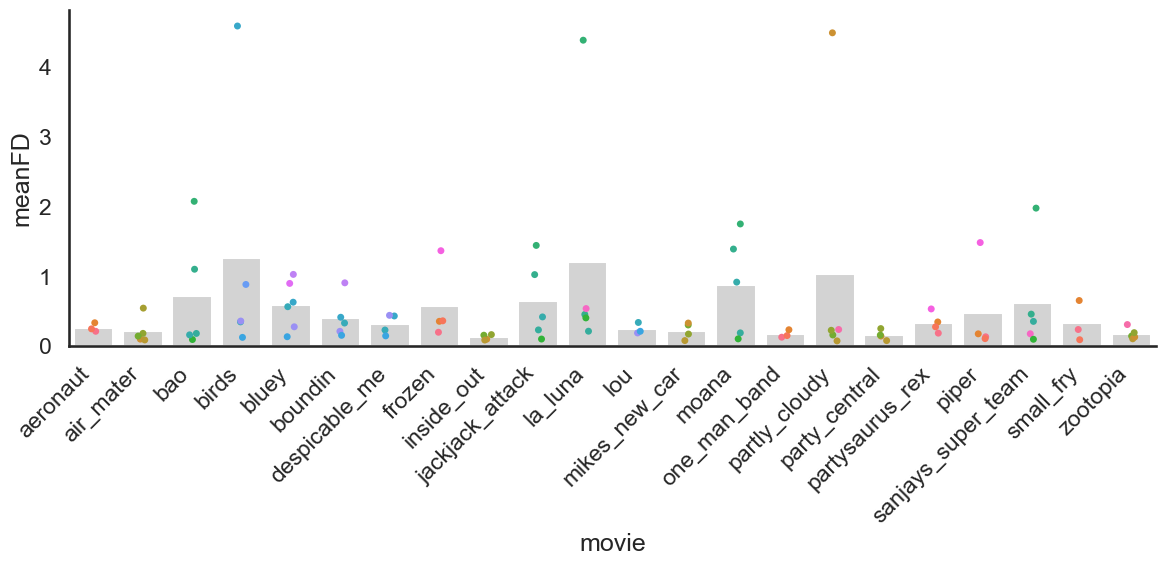

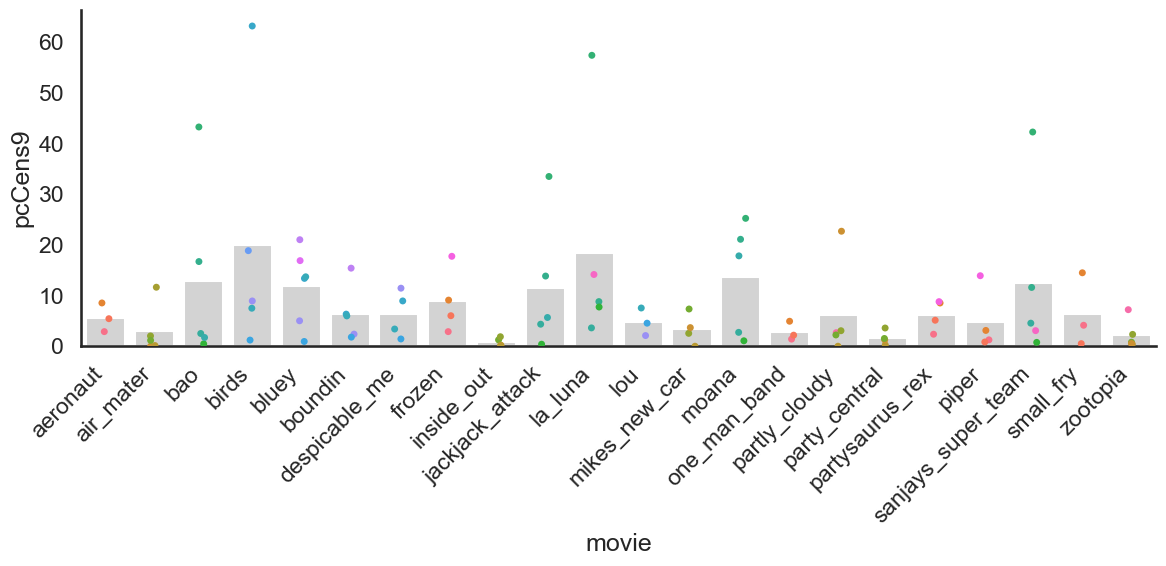

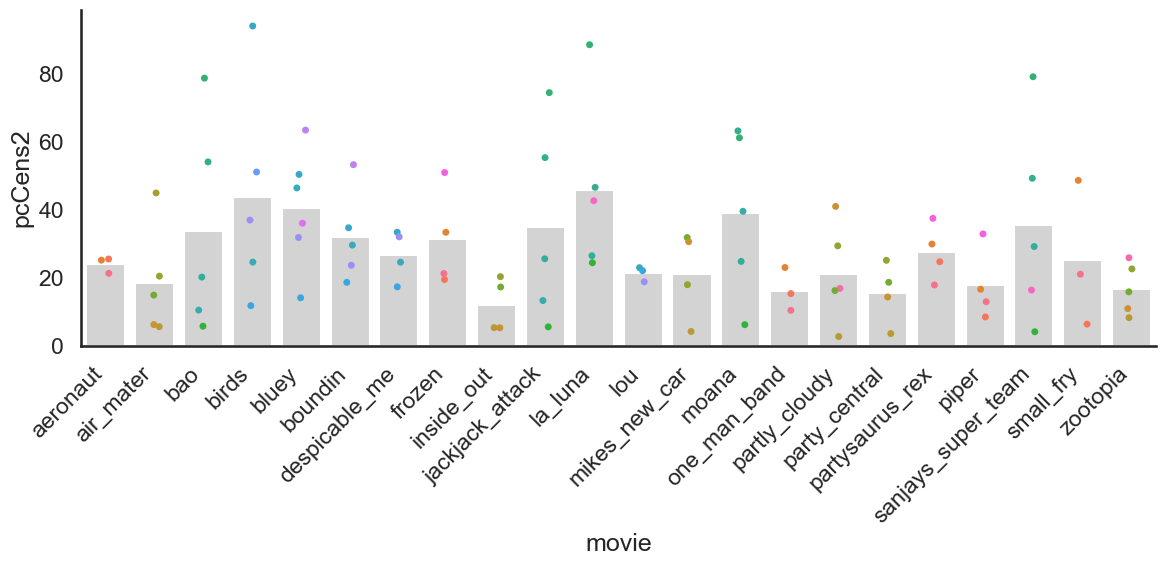

In [18]:
tempdata = data.loc[(data['age']==7) | (data['age']==8),:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages78_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

# get timeseries of motion across clips

In [19]:
clipmotion = {}
for mov in clipinfo.index:
    clipmotion[mov] = pd.DataFrame(index=range(0,3001))

In [ ]:
for sub in subs:
    print(sub)
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_data_processed.csv'.format(sub)), index_col=0)
    clips = np.unique(subdata['title'].dropna())
    for clip in clips:
        temp = subdata.loc[subdata['title']==clip,'FD50'].to_numpy()
        clipmotion[clip].loc[:temp.shape[0]-1,sub] = temp
        

In [21]:
for mov in clipinfo.index:
    clipmotion[mov] = clipmotion[mov].dropna(axis=0,how='all')

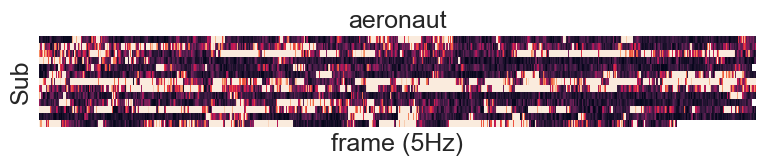

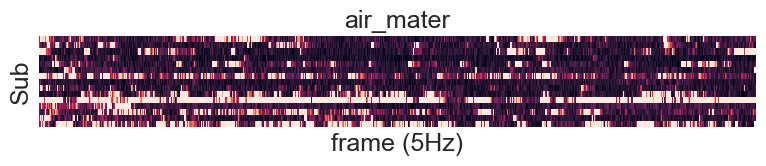

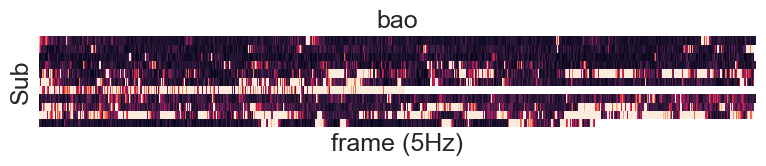

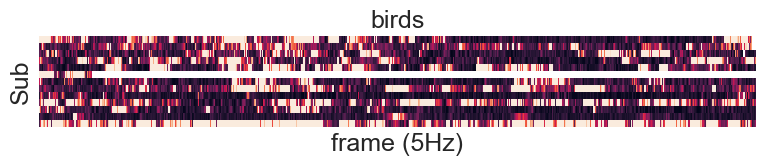

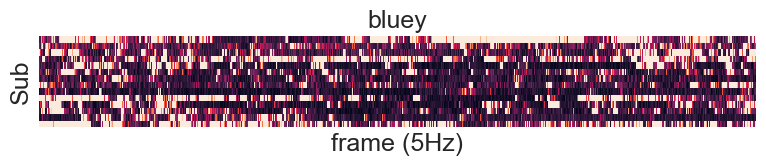

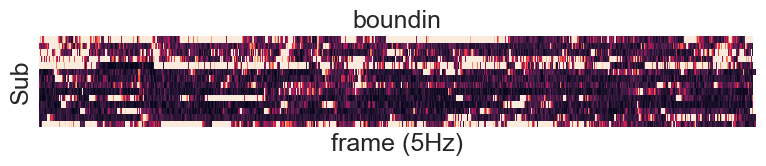

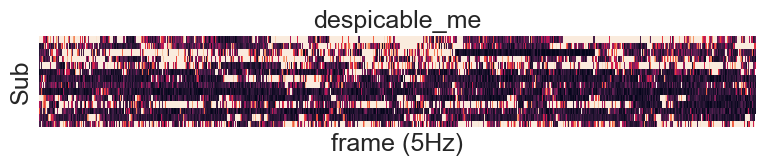

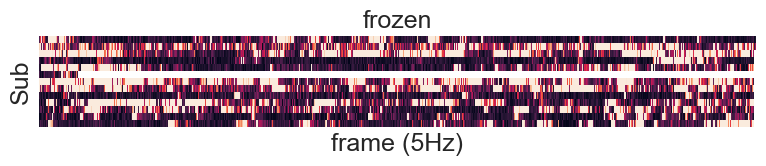

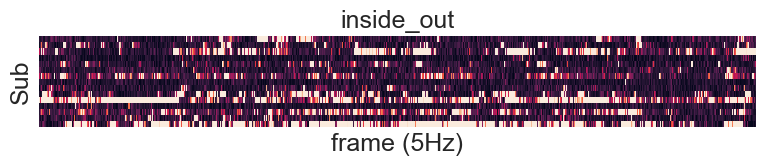

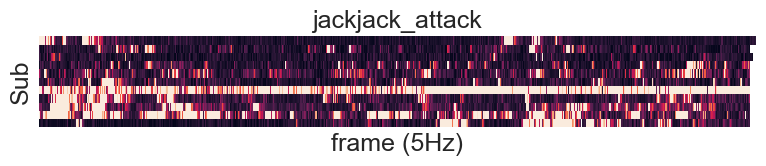

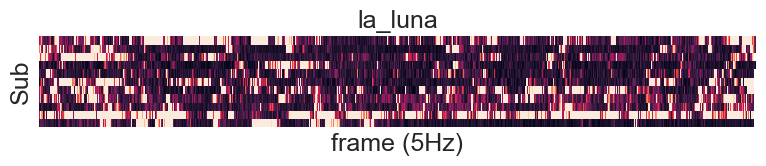

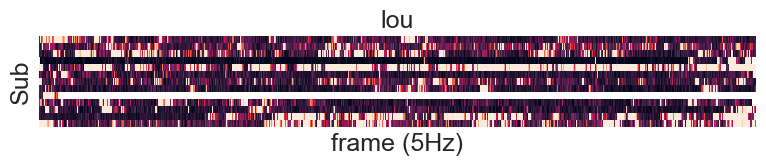

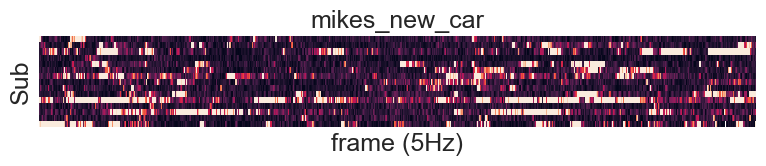

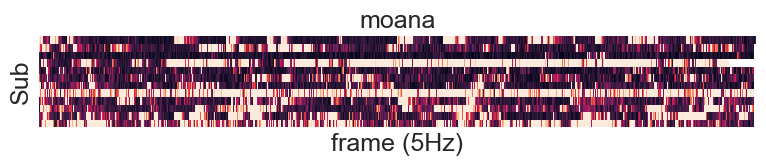

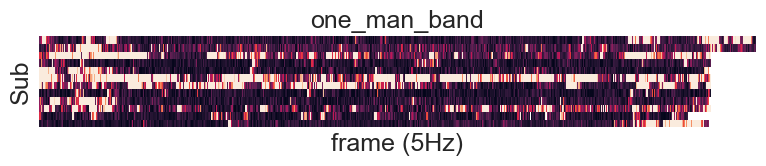

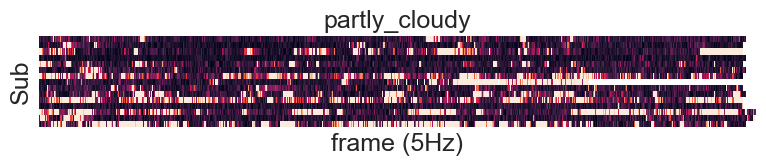

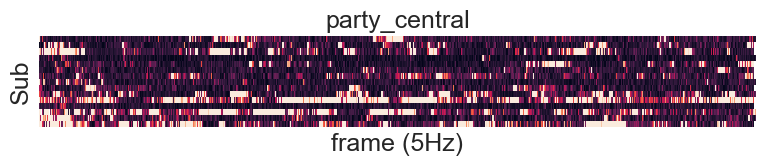

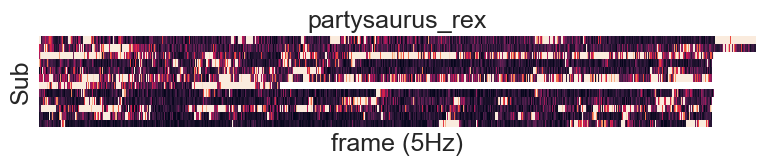

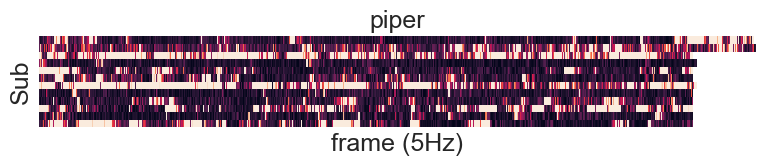

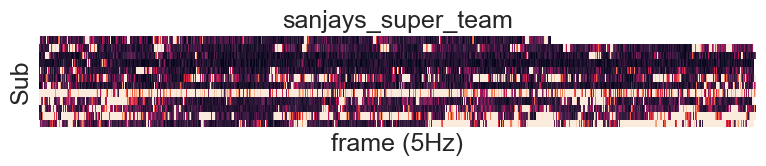

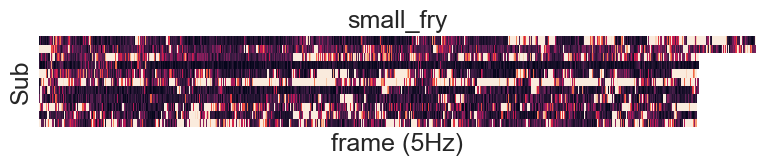

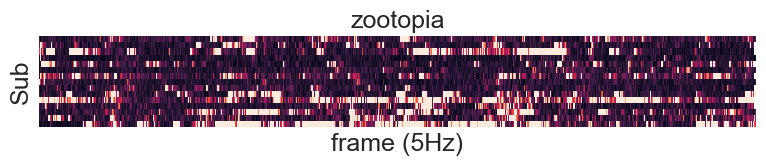

In [22]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_FD_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

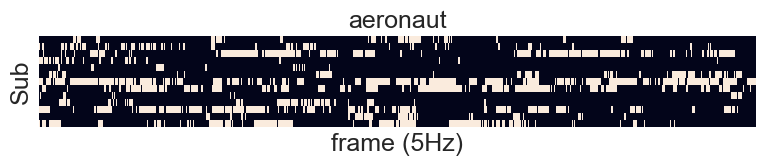

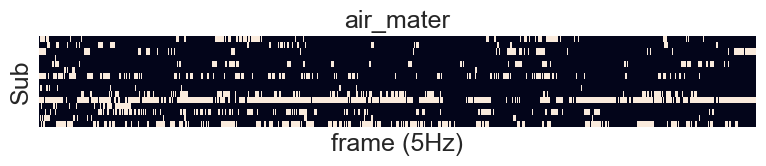

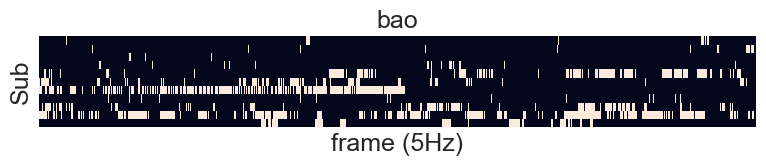

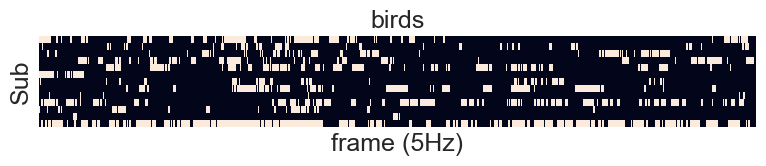

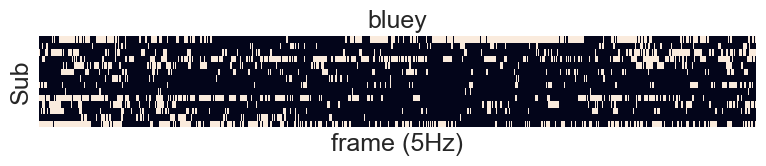

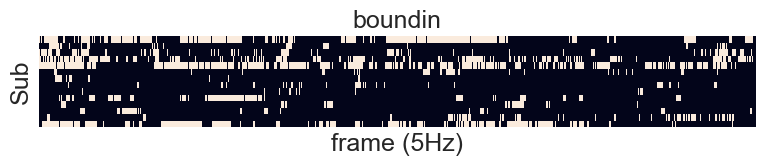

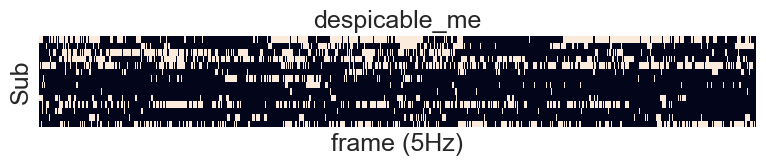

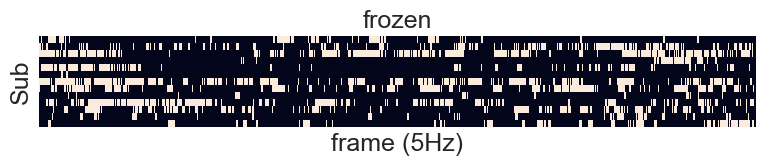

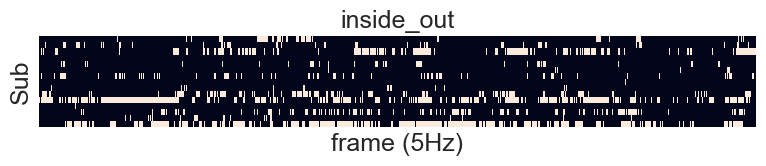

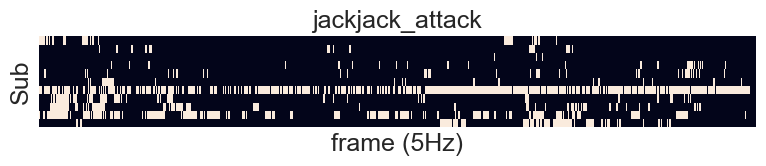

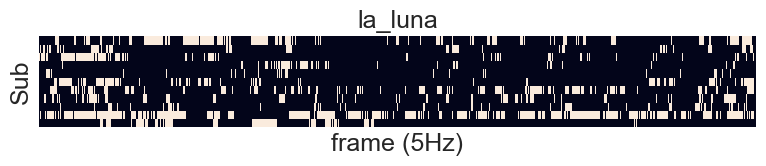

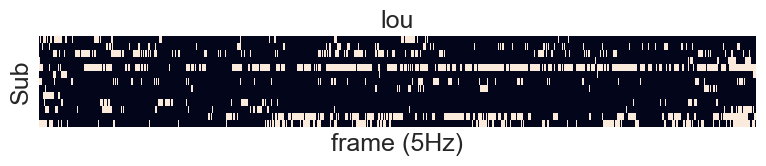

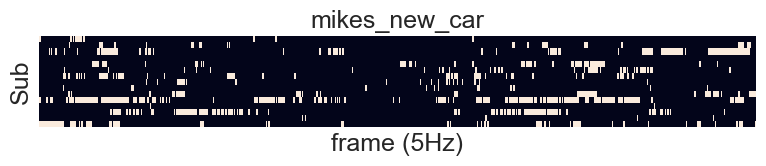

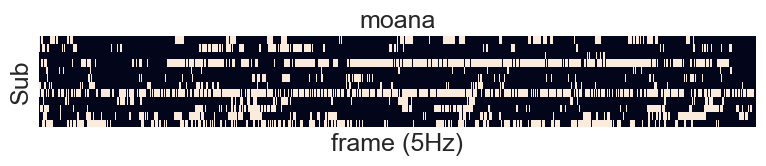

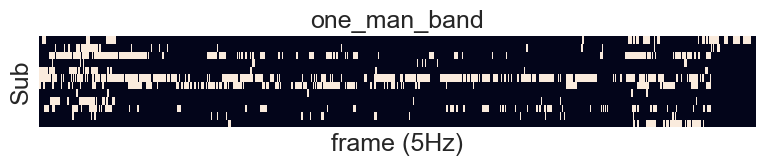

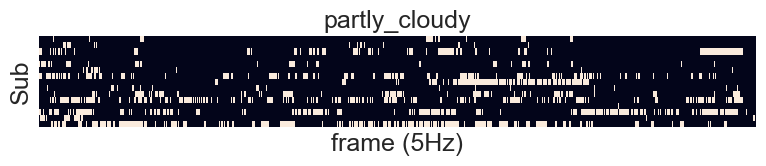

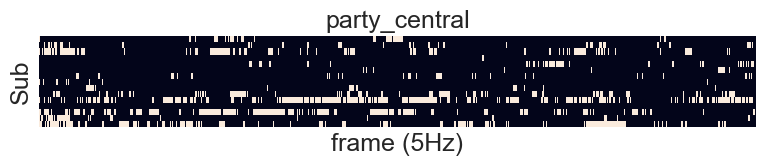

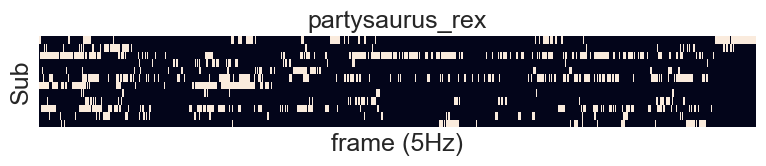

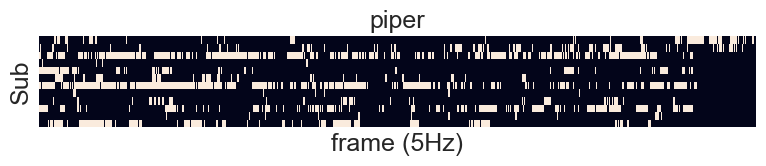

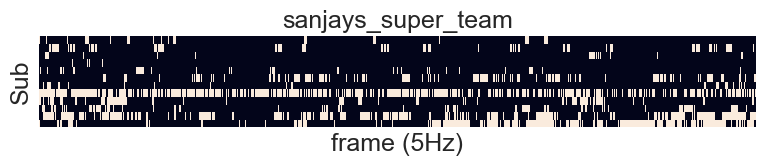

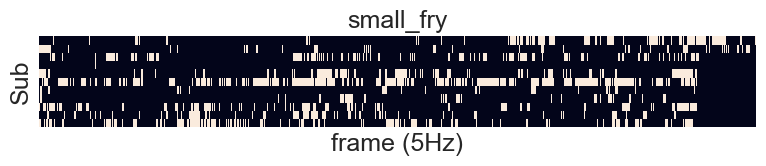

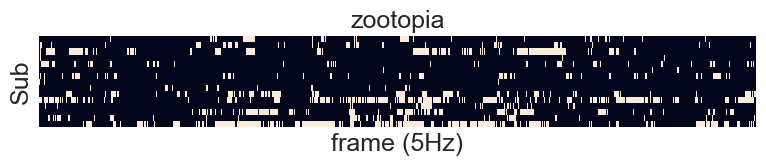

In [23]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T>0.9, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_cens09_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

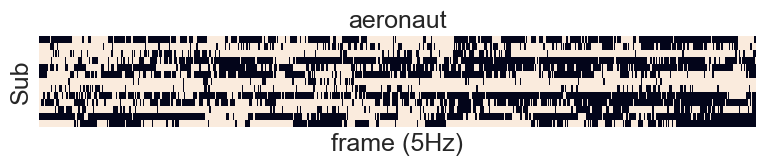

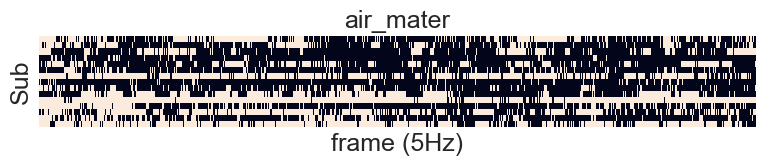

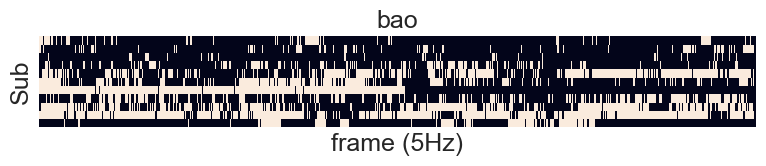

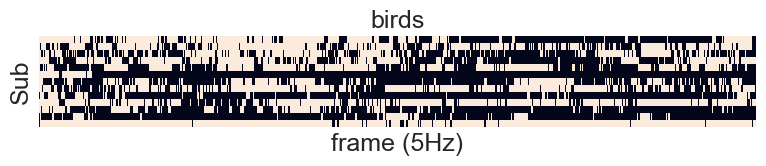

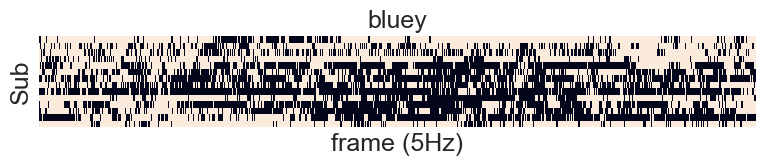

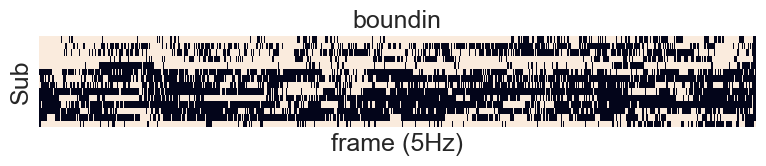

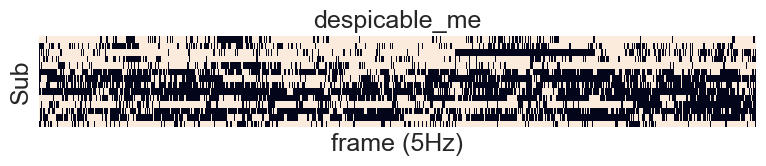

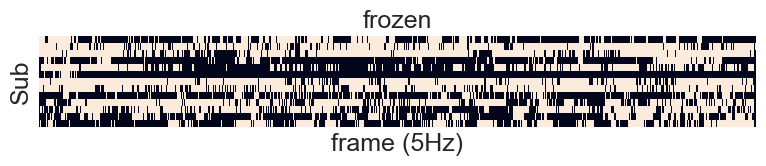

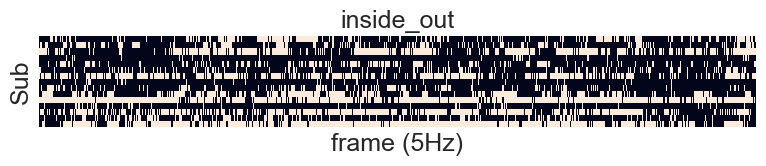

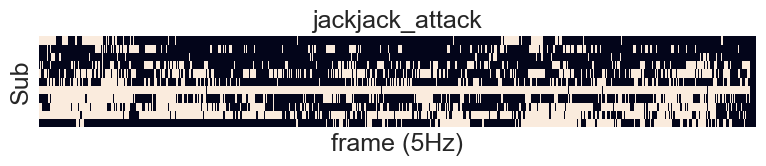

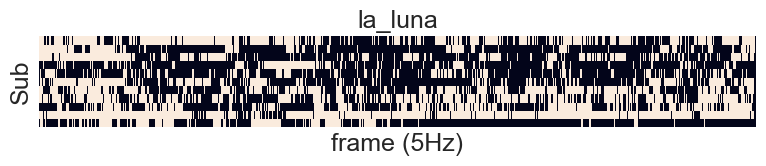

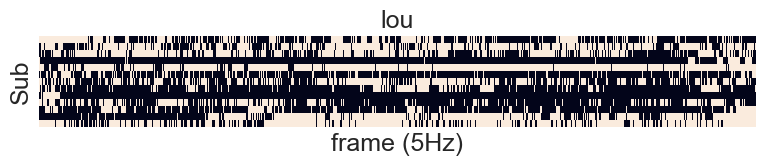

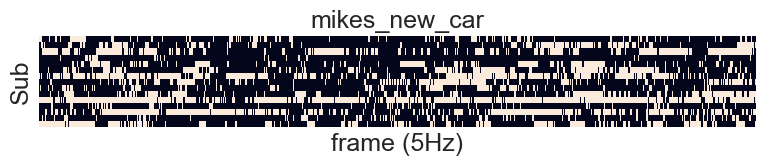

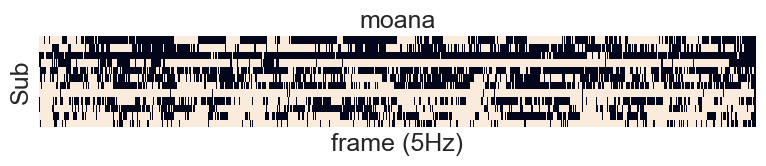

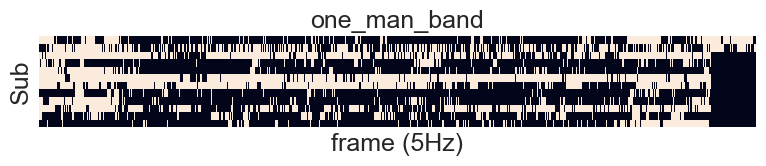

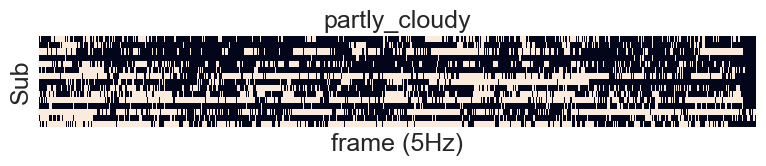

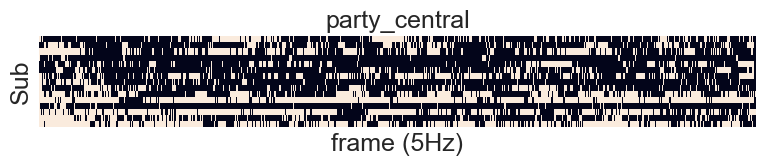

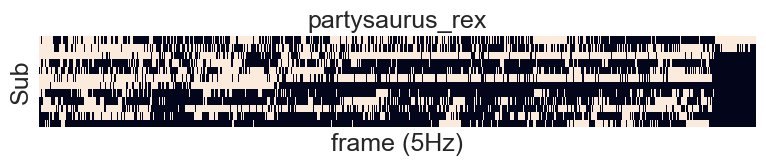

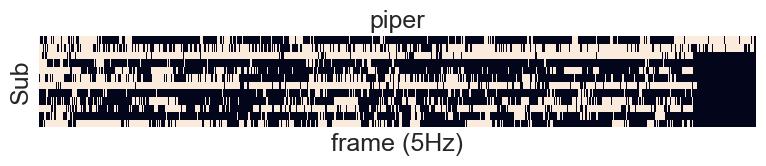

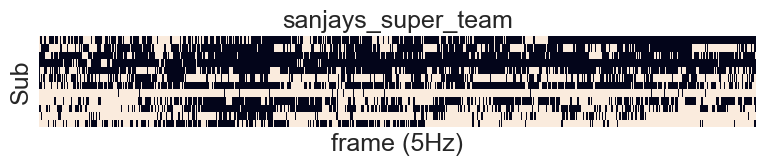

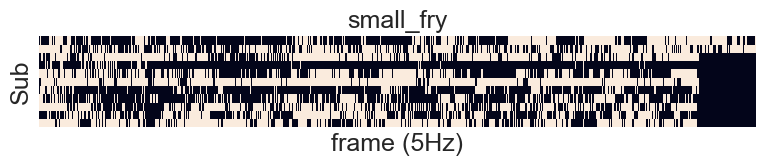

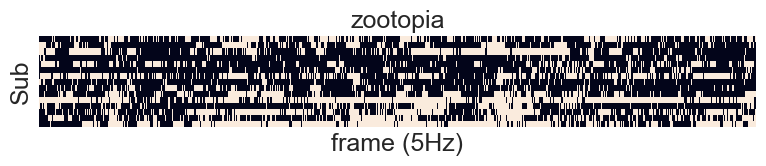

In [24]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T>0.2, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_cens02_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

# examine ratings

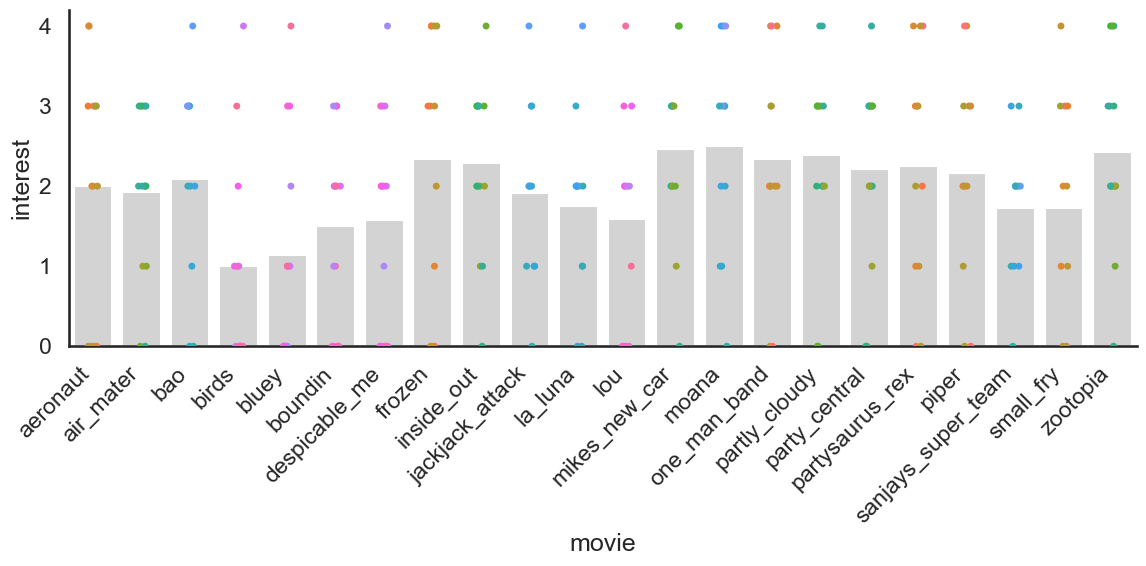

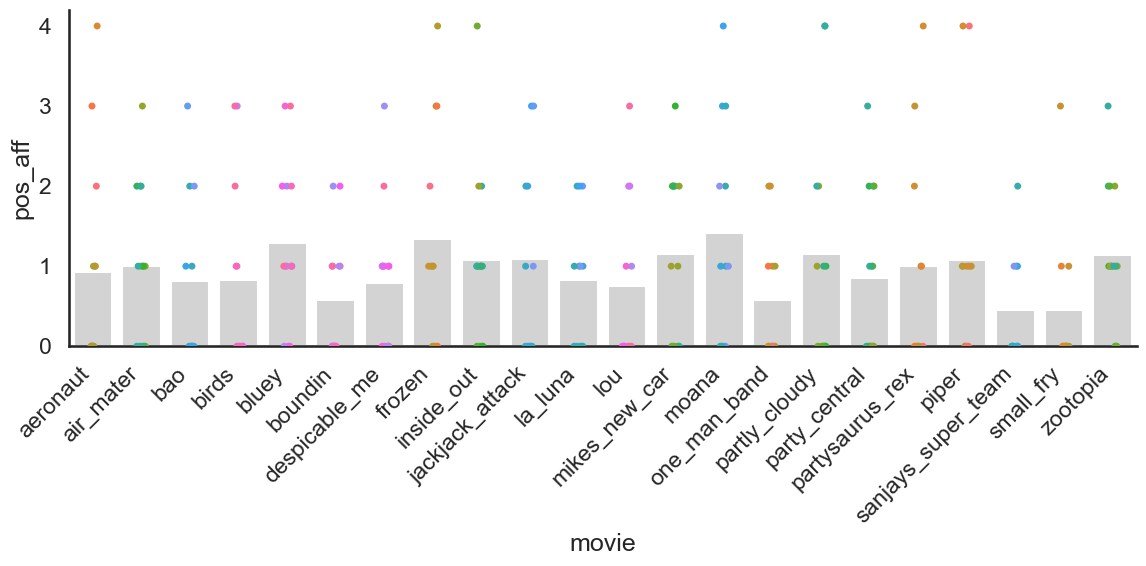

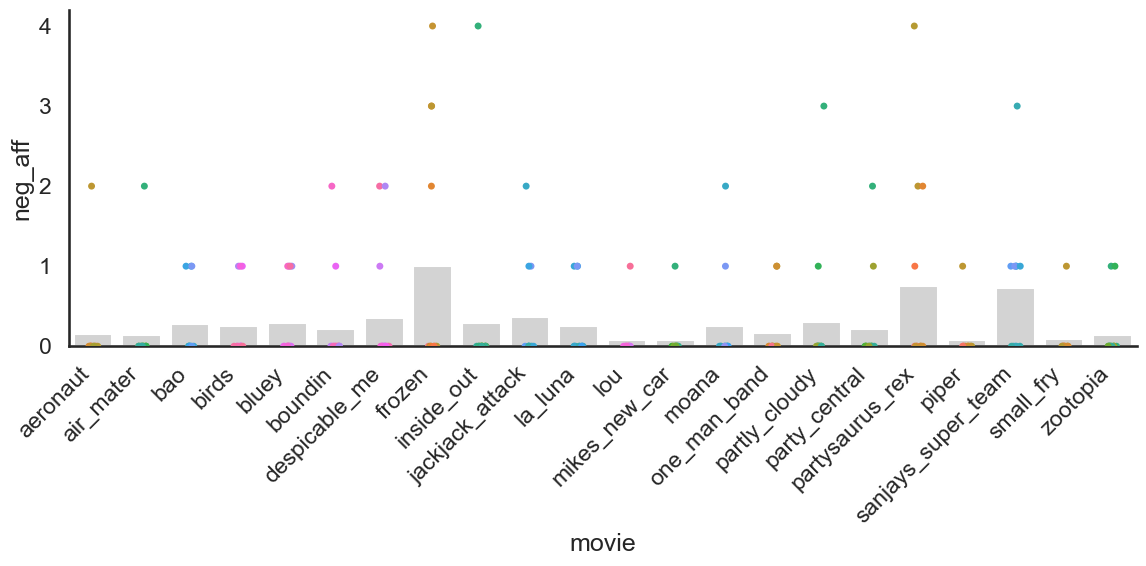

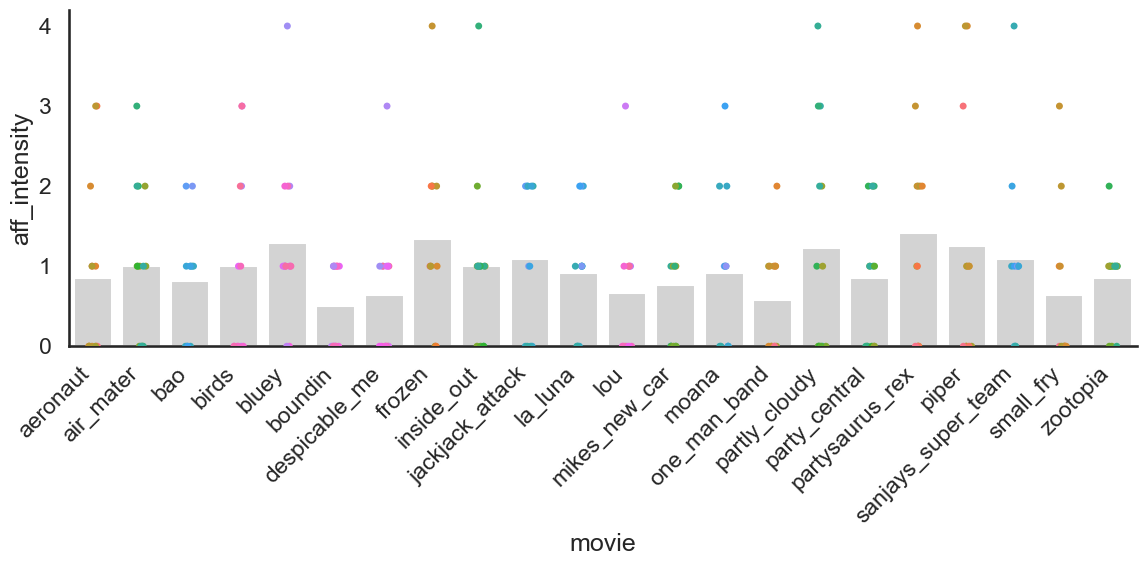

In [25]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_affect_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

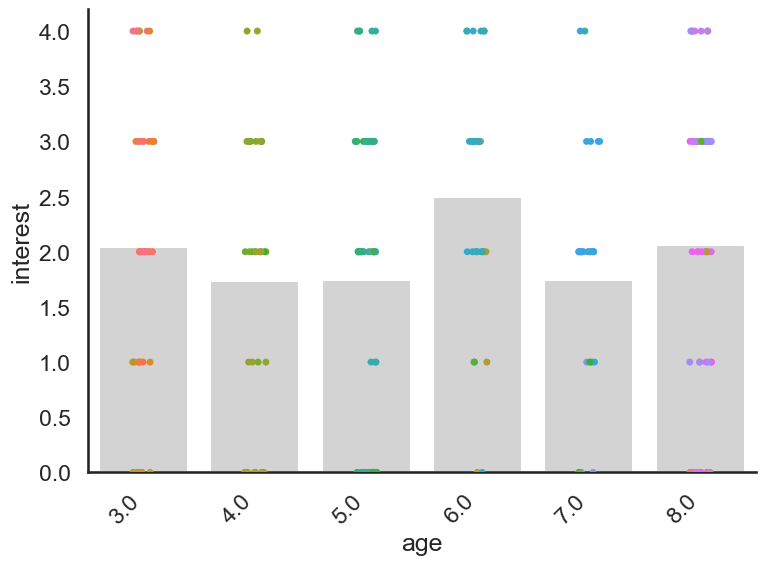

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

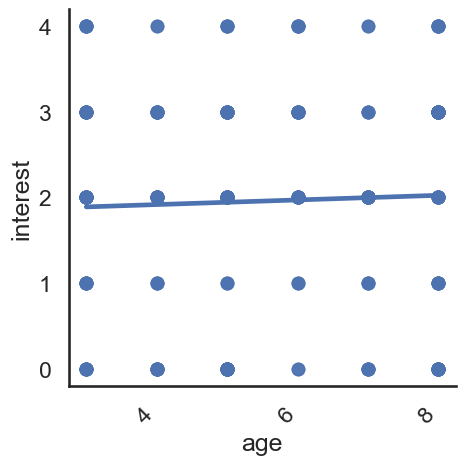

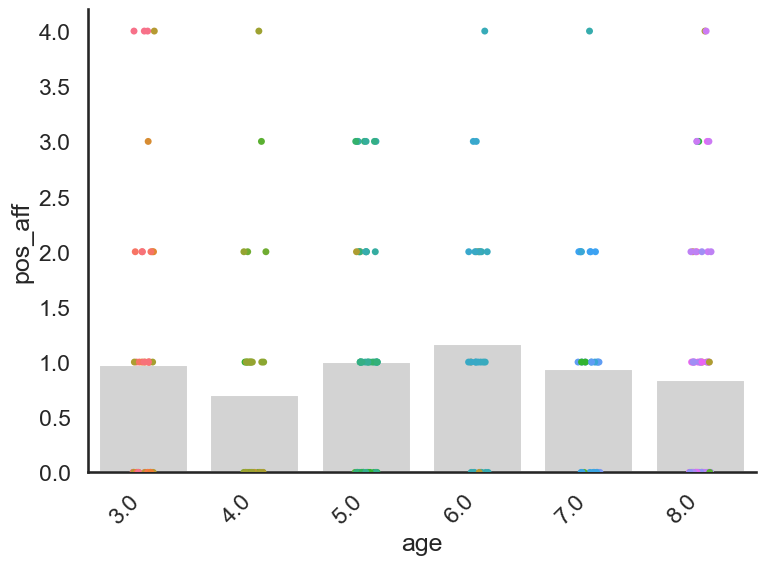

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

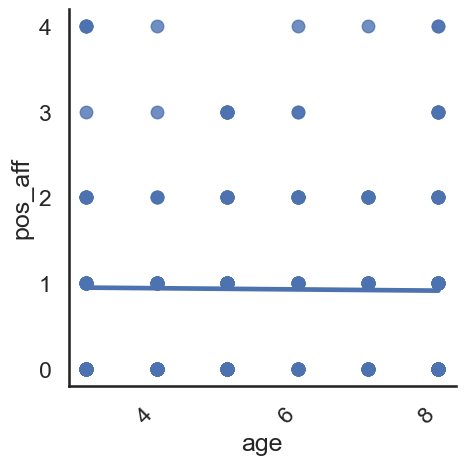

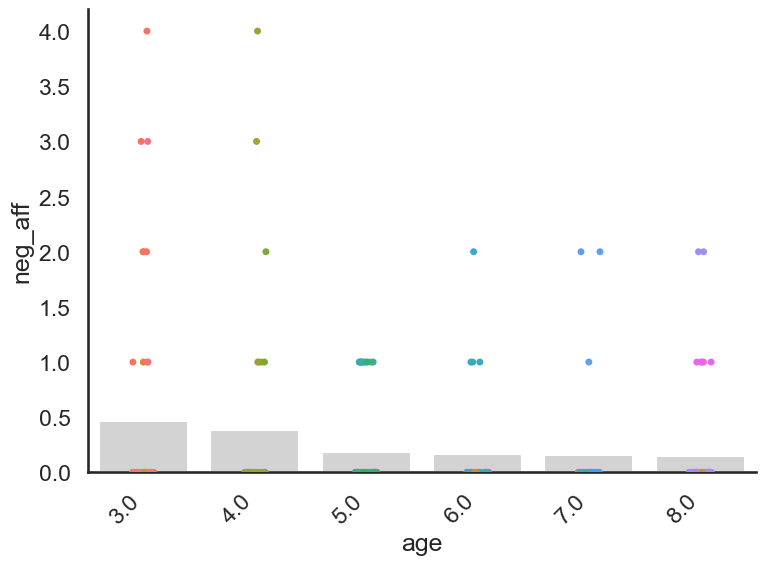

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

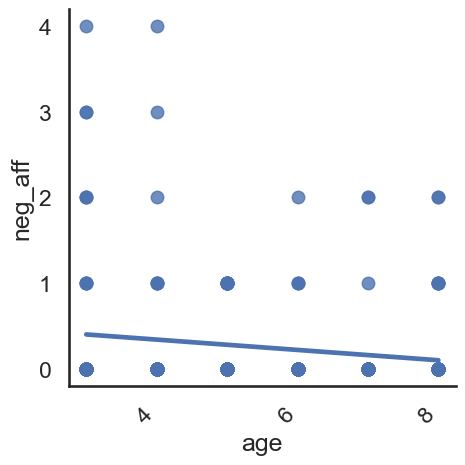

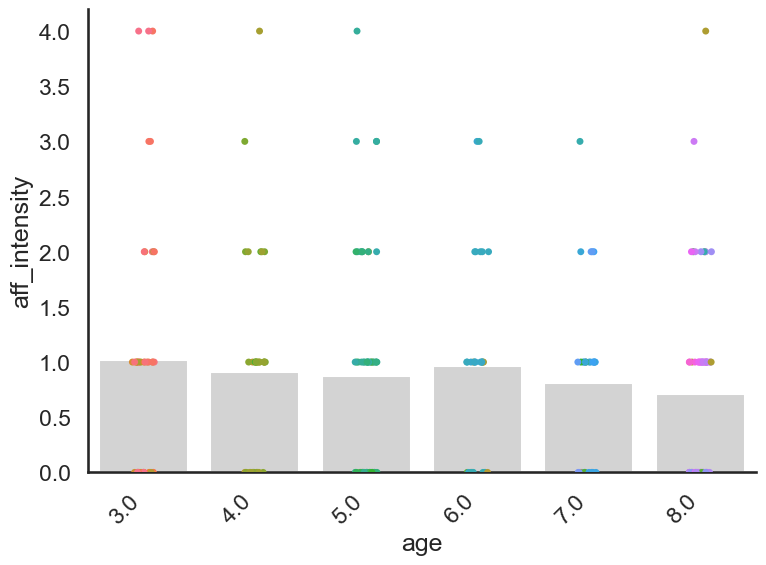

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

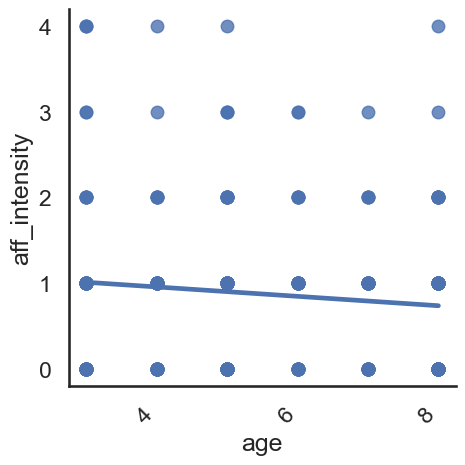

In [26]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v,x='age', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='age', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_affect_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(8,6))
    sns.lmplot(y=v,x='age', data=data, scatter=True, ci=None)
    #sns.stripplot(y=v,x='age', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_affect_{0}_lineplot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()


################### interest - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8385   
Min. group size:  1       Log-Likelihood:     -378.6606
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.836    0.162 11.364 0.000  1.519  2.152
human         0.232    0.137  1.690 0.091 -0.037  0.500
sub Var       0.890    0.265                           



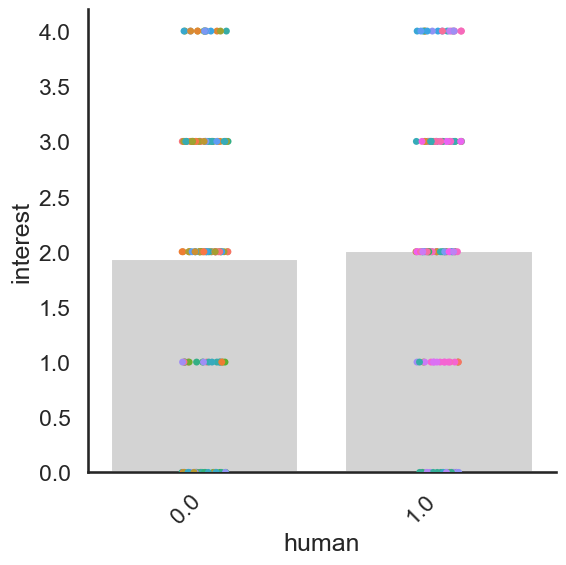


################### interest - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8510   
Min. group size:  1       Log-Likelihood:     -379.8852
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.889    0.167 11.292 0.000  1.561  2.217
speaking      0.092    0.129  0.714 0.475 -0.161  0.346
sub Var       0.873    0.259                           



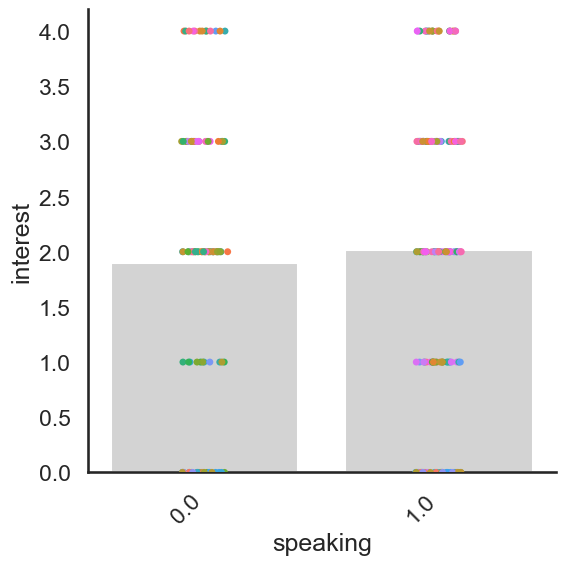


################### interest - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8316   
Min. group size:  1       Log-Likelihood:     -377.2116
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.194    0.178 12.294 0.000  1.845  2.544
contained    -0.329    0.137 -2.406 0.016 -0.597 -0.061
sub Var       0.864    0.259                           



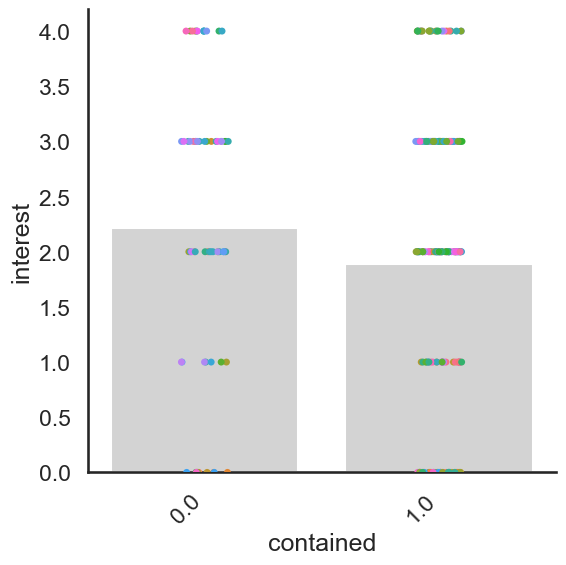


################### pos_aff - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.7978   
Min. group size:  1       Log-Likelihood:     -358.1735
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.958    0.123  7.786 0.000  0.717  1.199
human        -0.043    0.130 -0.334 0.739 -0.298  0.211
sub Var       0.390    0.145                           



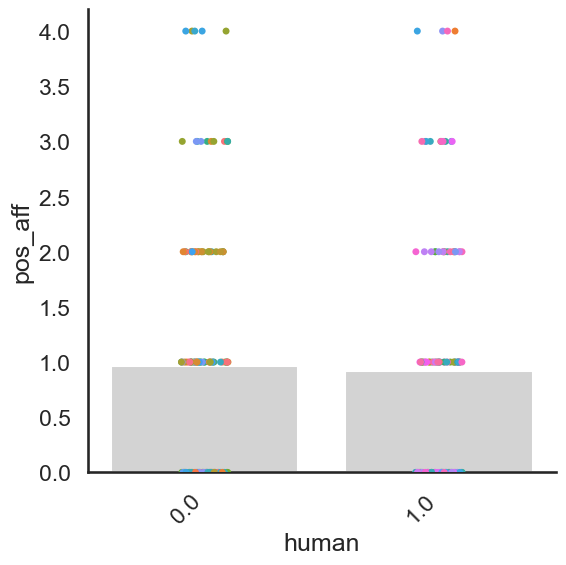


################### pos_aff - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.7928   
Min. group size:  1       Log-Likelihood:     -357.5161
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.842     0.131  6.417  0.000   0.585   1.100
speaking   0.152     0.123  1.234  0.217  -0.090   0.394
sub Var    0.390     0.145                              



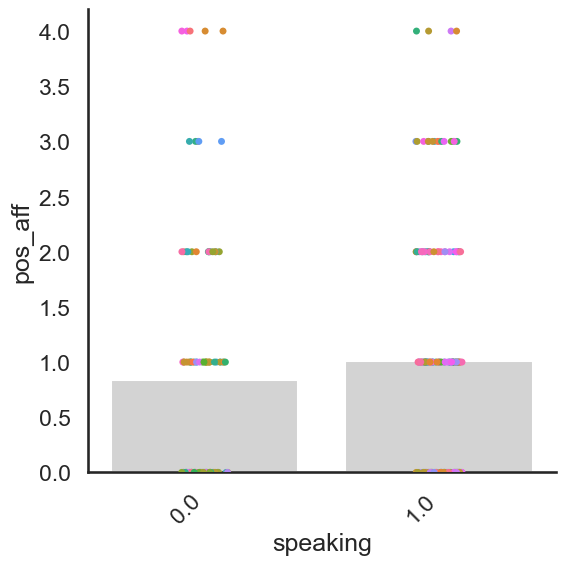


################### pos_aff - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.7835   
Min. group size:  1       Log-Likelihood:     -356.1026
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.143    0.146  7.845 0.000  0.857  1.428
contained    -0.272    0.132 -2.057 0.040 -0.531 -0.013
sub Var       0.388    0.145                           



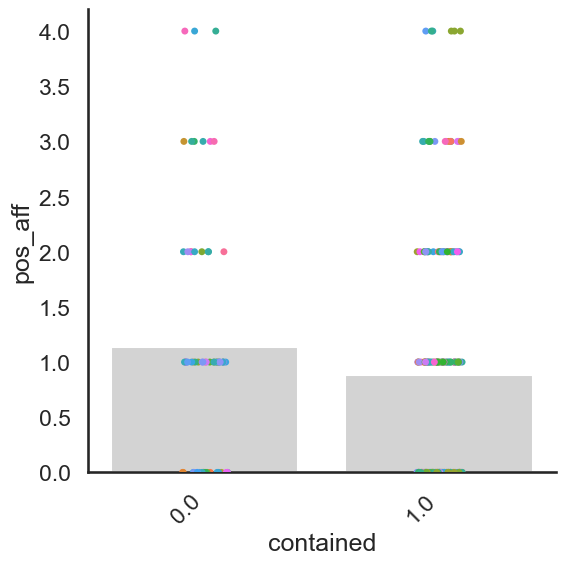


################### neg_aff - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.2995   
Min. group size:  1       Log-Likelihood:     -234.3238
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.223     0.072  3.080  0.002   0.081   0.365
human      0.053     0.079  0.665  0.506  -0.102   0.208
sub Var    0.127     0.078                              



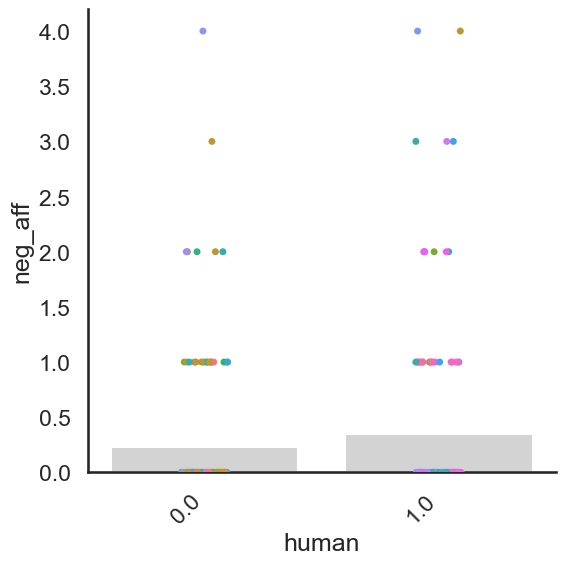


################### neg_aff - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.2952   
Min. group size:  1       Log-Likelihood:     -233.5496
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.180     0.078  2.296  0.022   0.026   0.334
speaking   0.109     0.075  1.447  0.148  -0.039   0.257
sub Var    0.133     0.081                              



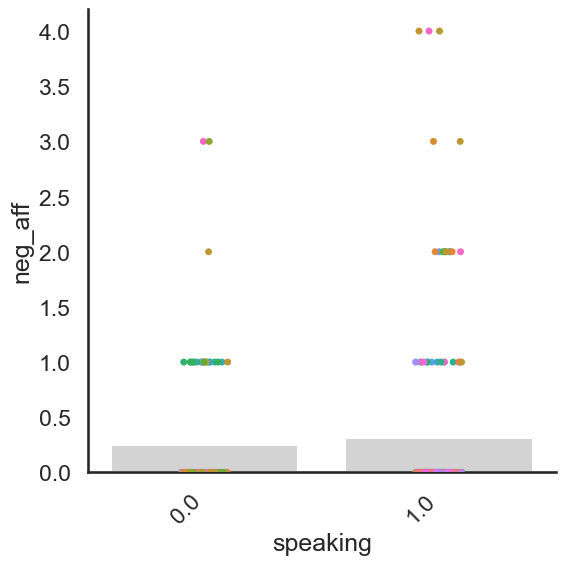


################### neg_aff - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.2965   
Min. group size:  1       Log-Likelihood:     -233.6142
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.331    0.088  3.771 0.000  0.159  0.502
contained    -0.109    0.081 -1.343 0.179 -0.269  0.050
sub Var       0.130    0.079                           



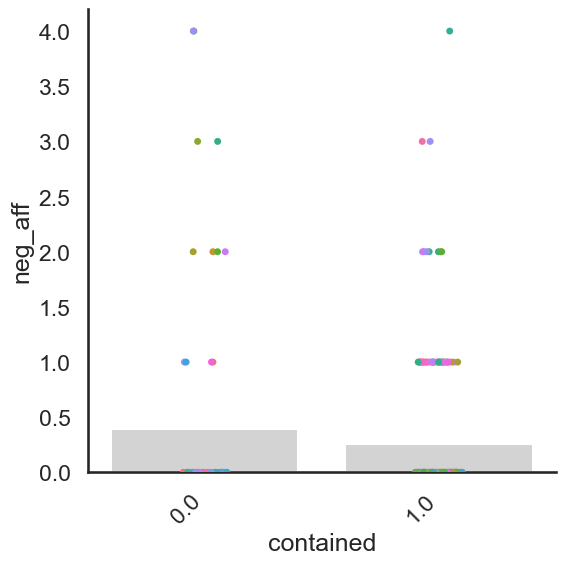


################### aff_intensity - human ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 250     Method:             REML         
No. Groups:       49      Scale:              0.5609       
Min. group size:  1       Log-Likelihood:     -318.9704    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.1                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.948     0.111   8.514  0.000   0.730   1.166
human        -0.141     0.110  -1.280  0.201  -0.356   0.075
sub Var       0.355     0.145                               



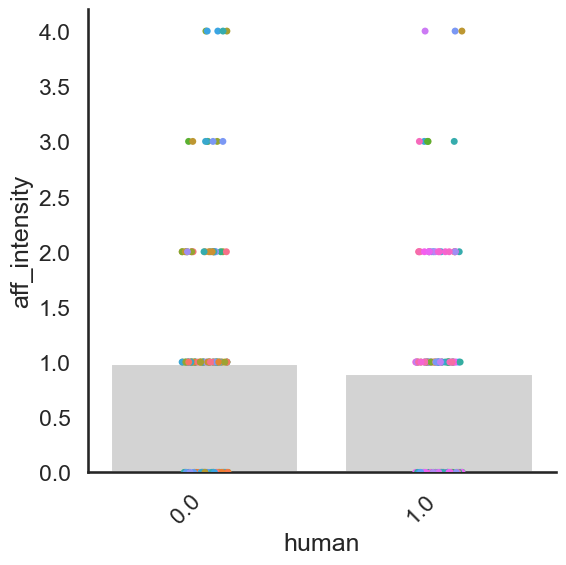


################### aff_intensity - speaking ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 250     Method:             REML         
No. Groups:       49      Scale:              0.5660       
Min. group size:  1       Log-Likelihood:     -319.8276    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.1                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.871     0.118  7.404  0.000   0.641   1.102
speaking       0.015     0.105  0.145  0.885  -0.190   0.220
sub Var        0.352     0.143                              



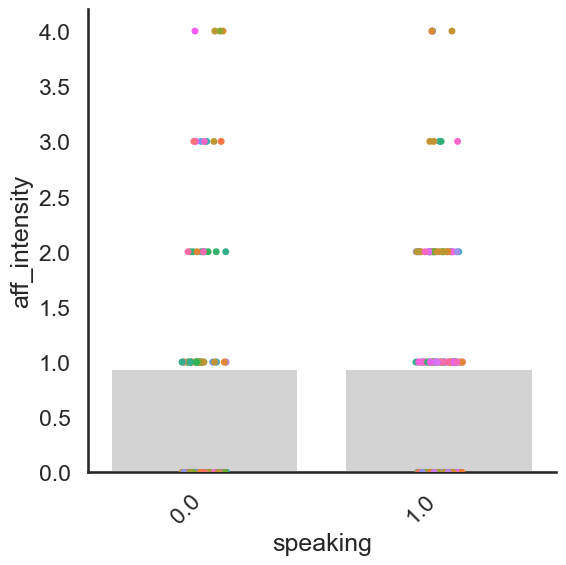


################### aff_intensity - contained ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 250     Method:             REML         
No. Groups:       49      Scale:              0.5661       
Min. group size:  1       Log-Likelihood:     -319.7492    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.1                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.896     0.130   6.913  0.000   0.642   1.151
contained    -0.021     0.113  -0.184  0.854  -0.241   0.200
sub Var       0.352     0.143                               



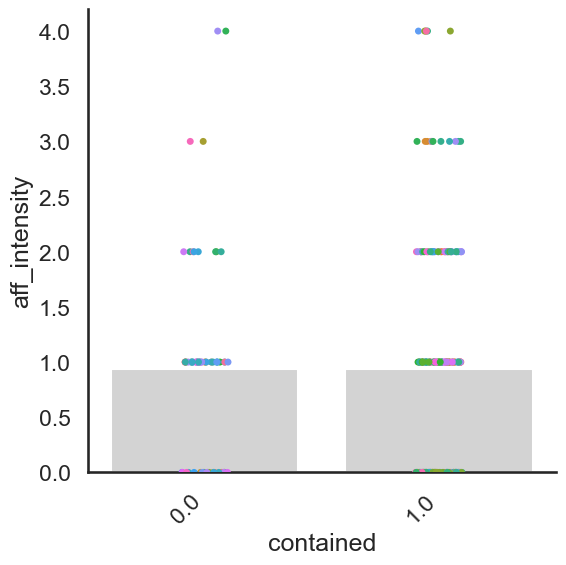

In [34]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1}'.format(v,f), groups='sub', data=temp).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.barplot(y=v,x=f, data=data, color='lightgray', errwidth=0)
        sns.stripplot(y=v,x=f, data=data, hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'fullsample_feature_{0}_affect_{1}_plot.png'.format(f,v)), dpi=200)
        plt.show()
        plt.close()